# 🔹 Seção 5.1 – Embeddings Avançados e Clustering
**Objetivo:** Explorar a evolução dos embeddings desde os métodos clássicos até os modernos, com foco em **clustering semântico** e aplicações práticas.

Esta aula demonstra como diferentes tipos de embeddings capturam similaridade semântica e como isso se traduz em **agrupamentos de alta qualidade** para análise de dados textuais.


## 🧠 Conceitos Fundamentais: A Evolução dos Embeddings

### **O que são Embeddings?**
**Embeddings** são representações vetoriais densas que mapeiam textos para um espaço onde **proximidade geométrica ≈ similaridade semântica**. Diferente de representações esparsas (BoW/TF-IDF), embeddings capturam **contexto** e **relações semânticas**.

### **Evolução Histórica**
1. **TF-IDF (1970s)**: Método clássico baseado em frequência de termos
2. **Word2Vec (2013)**: Primeira revolução - palavras similares ficam próximas
3. **BERT (2018)**: Contextualização bidirecional - mesma palavra, contextos diferentes
4. **Sentence-BERT (2019)**: Otimizado para similaridade de sentenças
5. **OpenAI Embeddings (2020+)**: Modelos de última geração, otimizados para tarefas específicas

### **Por que Embeddings são Ideais para Clustering?**
- **Proximidade semântica** = proximidade geométrica no espaço vetorial
- **Densidade**: Informação rica em poucas dimensões
- **Contextualização**: Captura nuances semânticas
- **Transfer Learning**: Aproveita conhecimento pré-treinado

### **Aplicações Práticas**
- **Clustering semântico**: Agrupar documentos por tópico
- **Busca semântica**: Encontrar documentos similares
- **Detecção de anomalias**: Identificar textos atípicos
- **Sistemas de recomendação**: Sugerir conteúdo similar


## ⚙️ Dependências e Configuração

Execute a célula abaixo para instalar todas as dependências necessárias:

```bash
!uv pip install -q sentence-transformers umap-learn scikit-learn pandas matplotlib plotly gensim openai streamlit hdbscan wordcloud elasticsearch docker
```

### **Principais Bibliotecas**
- `sentence-transformers`: Modelos BERT/SBERT modernos
- `gensim`: Word2Vec, GloVe clássicos
- `openai`: Embeddings da OpenAI (text-embedding-3-small/large)
- `scikit-learn`: Algoritmos de clustering e métricas
- `umap-learn`: Redução dimensional para visualização
- `plotly`: Visualizações interativas
- `elasticsearch`: Armazenamento e busca de embeddings
- `hdbscan`: Clustering hierárquico moderno


In [22]:
# ⚠️ CÉLULA ORIGINAL COMENTADA - PODE TRAVAR
# Use as células abaixo para carregar as bibliotecas de forma segura

"""
# ✅ Imports e Configuração - Versão Otimizada
# Esta célula foi comentada porque pode travar durante o carregamento
# Use as células 4-8 abaixo para carregar as bibliotecas de forma segura

import os
import re
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from typing import List, Dict, Tuple, Optional

# ... resto do código comentado ...
"""

print("⚠️  CÉLULA ORIGINAL COMENTADA")
print("💡 Execute as células 4-8 abaixo para carregar as bibliotecas de forma segura")
print("🔧 Isso evita travamentos durante o carregamento de bibliotecas pesadas")


⚠️  CÉLULA ORIGINAL COMENTADA
💡 Execute as células 4-8 abaixo para carregar as bibliotecas de forma segura
🔧 Isso evita travamentos durante o carregamento de bibliotecas pesadas


In [23]:
# 🔧 Configuração de Variáveis de Ambiente
# Esta célula carrega as configurações do arquivo .env

import os
from pathlib import Path

# Tentar carregar python-dotenv se disponível
try:
    from dotenv import load_dotenv
    print("✅ python-dotenv disponível")
    
    # Procurar arquivo .env em diferentes locais (em ordem de prioridade)
    env_paths = [
        Path.cwd() / 'setup' / '.env',  # Primeiro: pasta setup/
        Path.cwd() / '.env',            # Segundo: diretório raiz
        Path.cwd() / 'setup' / 'config_example.env'  # Terceiro: arquivo de exemplo
    ]
    
    env_loaded = False
    for env_path in env_paths:
        if env_path.exists():
            load_dotenv(env_path)
            print(f"✅ Arquivo .env carregado: {env_path}")
            env_loaded = True
            break
    
    if not env_loaded:
        print("⚠️  Nenhum arquivo .env encontrado, usando variáveis do sistema")
        
except ImportError:
    print("⚠️  python-dotenv não instalado, usando variáveis do sistema")
    print("💡 Para instalar: pip install python-dotenv")

# Carregar configurações do .env
MAX_CHARS_PER_REQUEST = int(os.getenv('MAX_CHARS_PER_REQUEST', 30000))
BATCH_SIZE_SMALL_TEXTS = int(os.getenv('BATCH_SIZE_SMALL_TEXTS', 8))
BATCH_SIZE_MEDIUM_TEXTS = int(os.getenv('BATCH_SIZE_MEDIUM_TEXTS', 4))
BATCH_SIZE_LARGE_TEXTS = int(os.getenv('BATCH_SIZE_LARGE_TEXTS', 2))
DATASET_SIZE = int(os.getenv('DATASET_SIZE', 10000))
TEXT_MIN_LENGTH = int(os.getenv('TEXT_MIN_LENGTH', 50))
MAX_CLUSTERS = int(os.getenv('MAX_CLUSTERS', 20))
CLUSTERING_RANDOM_STATE = int(os.getenv('CLUSTERING_RANDOM_STATE', 42))
PLOT_WIDTH = int(os.getenv('PLOT_WIDTH', 800))
PLOT_HEIGHT = int(os.getenv('PLOT_HEIGHT', 600))
LOG_LEVEL = os.getenv('LOG_LEVEL', 'INFO')
SAVE_MODELS = os.getenv('SAVE_MODELS', 'true').lower() == 'true'
SAVE_RESULTS = os.getenv('SAVE_RESULTS', 'true').lower() == 'true'
ELASTICSEARCH_HOST = os.getenv('ELASTICSEARCH_HOST', 'localhost')
ELASTICSEARCH_PORT = int(os.getenv('ELASTICSEARCH_PORT', 9200))

# Verificar se a chave da OpenAI está configurada
openai_key = os.getenv('OPENAI_API_KEY')
if openai_key and openai_key != 'sk-your-openai-key-here':
    print("✅ Chave da OpenAI configurada")
    OPENAI_AVAILABLE = True
else:
    print("⚠️  Chave da OpenAI não configurada")
    print("💡 Configure OPENAI_API_KEY no arquivo setup/.env para usar embeddings da OpenAI")
    OPENAI_AVAILABLE = False

print(f"🔧 Configuração carregada com sucesso!")
print(f"📊 Configurações carregadas:")
print(f"   MAX_CHARS_PER_REQUEST: {MAX_CHARS_PER_REQUEST}")
print(f"   BATCH_SIZE_SMALL_TEXTS: {BATCH_SIZE_SMALL_TEXTS}")
print(f"   BATCH_SIZE_MEDIUM_TEXTS: {BATCH_SIZE_MEDIUM_TEXTS}")
print(f"   BATCH_SIZE_LARGE_TEXTS: {BATCH_SIZE_LARGE_TEXTS}")
print(f"   DATASET_SIZE: {DATASET_SIZE}")
print(f"   TEXT_MIN_LENGTH: {TEXT_MIN_LENGTH}")
print(f"   MAX_CLUSTERS: {MAX_CLUSTERS}")
print(f"   CLUSTERING_RANDOM_STATE: {CLUSTERING_RANDOM_STATE}")


✅ python-dotenv disponível
✅ Arquivo .env carregado: /Users/ivanvarella/Documents/Dados/9 - Mestrado/1 - Disciplinas 2025/2025.2/PPGEP9002 - INTELIGÊNCIA COMPUTACIONAL PARA ENGENHARIA DE PRODUÇÃO - T01/1 - Extra - Professor/Projetos/Embeddings_5.1/setup/.env
✅ Chave da OpenAI configurada
🔧 Configuração carregada com sucesso!
📊 Configurações carregadas:
   MAX_CHARS_PER_REQUEST: 30000
   BATCH_SIZE_SMALL_TEXTS: 8
   BATCH_SIZE_MEDIUM_TEXTS: 4
   BATCH_SIZE_LARGE_TEXTS: 2
   DATASET_SIZE: 10000
   TEXT_MIN_LENGTH: 50
   MAX_CLUSTERS: 20
   CLUSTERING_RANDOM_STATE: 42


In [24]:
# 🧪 Teste Rápido de Imports
print("🧪 TESTE RÁPIDO DE IMPORTS")
print("=" * 30)

# Teste básico
try:
    import numpy as np
    print("✅ NumPy OK")
except Exception as e:
    print(f"❌ NumPy erro: {e}")

try:
    import pandas as pd
    print("✅ Pandas OK")
except Exception as e:
    print(f"❌ Pandas erro: {e}")

try:
    import matplotlib.pyplot as plt
    print("✅ Matplotlib OK")
except Exception as e:
    print(f"❌ Matplotlib erro: {e}")

try:
    import seaborn as sns
    print("✅ Seaborn OK")
except Exception as e:
    print(f"❌ Seaborn erro: {e}")

try:
    from sklearn.datasets import fetch_20newsgroups
    print("✅ Scikit-learn OK")
except Exception as e:
    print(f"❌ Scikit-learn erro: {e}")

print("\n🎯 Teste básico concluído!")


🧪 TESTE RÁPIDO DE IMPORTS
✅ NumPy OK
✅ Pandas OK
✅ Matplotlib OK
✅ Seaborn OK
✅ Scikit-learn OK

🎯 Teste básico concluído!


In [25]:
# 🔄 Imports Problemáticos - Teste Individual
print("🔄 Testando imports que podem travar...")

# Teste Sentence Transformers (pode ser lento)
try:
    print("🔄 Carregando Sentence Transformers...")
    from sentence_transformers import SentenceTransformer
    print("✅ Sentence Transformers carregado com sucesso")
    SENTENCE_TRANSFORMERS_OK = True
except Exception as e:
    print(f"❌ Sentence Transformers erro: {e}")
    SENTENCE_TRANSFORMERS_OK = False

# Teste Gensim (pode ser lento)
try:
    print("🔄 Carregando Gensim...")
    import gensim
    from gensim.models import Word2Vec
    print("✅ Gensim carregado com sucesso")
    GENSIM_OK = True
except Exception as e:
    print(f"❌ Gensim erro: {e}")
    GENSIM_OK = False

# Teste Plotly
try:
    print("🔄 Carregando Plotly...")
    import plotly.express as px
    print("✅ Plotly carregado com sucesso")
    PLOTLY_OK = True
except Exception as e:
    print(f"❌ Plotly erro: {e}")
    PLOTLY_OK = False

print(f"\n📊 RESUMO DOS TESTES:")
print(f"   Sentence Transformers: {'✅' if SENTENCE_TRANSFORMERS_OK else '❌'}")
print(f"   Gensim: {'✅' if GENSIM_OK else '❌'}")
print(f"   Plotly: {'✅' if PLOTLY_OK else '❌'}")


🔄 Testando imports que podem travar...
🔄 Carregando Sentence Transformers...
✅ Sentence Transformers carregado com sucesso
🔄 Carregando Gensim...
✅ Gensim carregado com sucesso
🔄 Carregando Plotly...
✅ Plotly carregado com sucesso

📊 RESUMO DOS TESTES:
   Sentence Transformers: ✅
   Gensim: ✅
   Plotly: ✅


In [26]:
# 🚀 Imports Essenciais - Versão Simplificada
print("🚀 CARREGANDO IMPORTS ESSENCIAIS")
print("=" * 40)

# Imports básicos
import os
import re
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from typing import List, Dict, Tuple, Optional

print("✅ Imports básicos carregados")

# Scikit-learn
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import (
    silhouette_score, adjusted_rand_score, normalized_mutual_info_score,
    homogeneity_score, completeness_score, v_measure_score,
    calinski_harabasz_score, davies_bouldin_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

print("✅ Scikit-learn carregado")

# Configurações
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 200)

# Configuração do matplotlib
try:
    plt.style.use('seaborn')
except:
    try:
        plt.style.use('seaborn-v0_8')
    except:
        plt.style.use('default')

sns.set_palette("husl")

print("✅ Configurações aplicadas")

# Flags de disponibilidade (serão definidas nas próximas células)
UMAP_AVAILABLE = False
HDBSCAN_AVAILABLE = False
OPENAI_AVAILABLE = False
ELASTICSEARCH_AVAILABLE = False

print("\n🎉 IMPORTS ESSENCIAIS CONCLUÍDOS!")
print("💡 Execute as próximas células para carregar bibliotecas opcionais")


🚀 CARREGANDO IMPORTS ESSENCIAIS
✅ Imports básicos carregados
✅ Scikit-learn carregado
✅ Configurações aplicadas

🎉 IMPORTS ESSENCIAIS CONCLUÍDOS!
💡 Execute as próximas células para carregar bibliotecas opcionais


In [27]:
# 📚 Carregar Bibliotecas Opcionais
print("📚 CARREGANDO BIBLIOTECAS OPCIONAIS")
print("=" * 40)

# UMAP
try:
    import umap
    UMAP_AVAILABLE = True
    print("✅ UMAP carregado")
except ImportError:
    UMAP_AVAILABLE = False
    print('⚠️ UMAP não instalado')

# HDBSCAN
try:
    import hdbscan
    HDBSCAN_AVAILABLE = True
    print("✅ HDBSCAN carregado")
except ImportError:
    HDBSCAN_AVAILABLE = False
    print('⚠️ HDBSCAN não instalado')

# OpenAI
try:
    import openai
    OPENAI_AVAILABLE = True
    print("✅ OpenAI carregado")
except ImportError:
    OPENAI_AVAILABLE = False
    print('⚠️ OpenAI não instalado')

# Elasticsearch
try:
    from elasticsearch import Elasticsearch
    ELASTICSEARCH_AVAILABLE = True
    print("✅ Elasticsearch carregado")
except ImportError:
    ELASTICSEARCH_AVAILABLE = False
    print('⚠️ Elasticsearch não instalado')

print(f"\n📊 STATUS DAS BIBLIOTECAS:")
print(f"   UMAP: {'✅' if UMAP_AVAILABLE else '❌'}")
print(f"   HDBSCAN: {'✅' if HDBSCAN_AVAILABLE else '❌'}")
print(f"   OpenAI: {'✅' if OPENAI_AVAILABLE else '❌'}")
print(f"   Elasticsearch: {'✅' if ELASTICSEARCH_AVAILABLE else '❌'}")


📚 CARREGANDO BIBLIOTECAS OPCIONAIS
✅ UMAP carregado
✅ HDBSCAN carregado
✅ OpenAI carregado
✅ Elasticsearch carregado

📊 STATUS DAS BIBLIOTECAS:
   UMAP: ✅
   HDBSCAN: ✅
   OpenAI: ✅
   Elasticsearch: ✅


## 🗄️ Gerenciamento de Cache Elasticsearch

### **Sistema Inteligente de Cache**
Este notebook implementa um sistema avançado de cache usando Elasticsearch que:

- **Evita reprocessamento**: Detecta embeddings já gerados e os reutiliza
- **Valida integridade**: Verifica se os dados salvos estão corretos via hash MD5
- **Economiza tempo**: TF-IDF (30s → 5s), Word2Vec (60s → 5s), BERT (120s → 5s), **OpenAI (30min → 5s!)**
- **Economiza dinheiro**: Evita chamadas desnecessárias à API da OpenAI
- **Rastreabilidade**: Cada embedding está vinculado ao documento original

### **Estrutura dos Índices**
```
📦 ELASTICSEARCH CACHE
├── 📄 documents_dataset     (Dataset original com IDs únicos)
├── 🧮 embeddings_tfidf      (5000 dimensões)
├── 🧮 embeddings_word2vec   (100 dimensões)  
├── 🧮 embeddings_bert       (768 dimensões)
├── 🧮 embeddings_sbert      (384 dimensões)
└── 🧮 embeddings_openai     (1536 dimensões)
```

### **Fluxo Inteligente**
1. **Verificação**: Checa se embeddings já existem
2. **Validação**: Confere integridade via hash dos textos
3. **Geração seletiva**: Gera apenas embeddings faltantes ou inválidos
4. **Salvamento**: Armazena com metadata completa


In [28]:
# 🗄️ Inicialização do Sistema de Cache Elasticsearch
print("🗄️ INICIALIZANDO SISTEMA DE CACHE ELASTICSEARCH")
print("=" * 60)

# Importar módulo de gerenciamento de cache
try:
    from elasticsearch_manager import (
        init_elasticsearch_cache, get_cache_status, save_dataset_to_cache,
        save_embeddings_to_cache, load_embeddings_from_cache, 
        check_embeddings_in_cache, clear_elasticsearch_cache
    )
    print("✅ Módulo de cache Elasticsearch carregado")
    CACHE_AVAILABLE = True
except ImportError as e:
    print(f"❌ Erro ao carregar módulo de cache: {e}")
    print("💡 Certifique-se de que o arquivo elasticsearch_manager.py está no diretório")
    CACHE_AVAILABLE = False

# Inicializar conexão com Elasticsearch
if CACHE_AVAILABLE:
    print("\n🔌 Conectando ao Elasticsearch...")
    cache_connected = init_elasticsearch_cache(
        host=ELASTICSEARCH_HOST,
        port=ELASTICSEARCH_PORT
    )
    
    if cache_connected:
        print("✅ Cache Elasticsearch inicializado com sucesso!")
        
        # Verificar status do cache
        print("\n📊 STATUS DO CACHE:")
        print("-" * 40)
        status = get_cache_status()
        
        if status.get("connected", False):
            print(f"🔌 Conexão: ✅ {status.get('host', 'N/A')}")
            print(f"📊 Índices encontrados: {len([k for k, v in status.get('indices', {}).items() if v.get('exists', False)])}")
            print(f"📋 Total de documentos: {status.get('total_docs', 0):,}")
            print(f"💾 Espaço usado: {status.get('total_size_mb', 0):.1f} MB")
            
            # Mostrar detalhes por índice
            print(f"\n📦 DETALHES DOS ÍNDICES:")
            for index_name, info in status.get('indices', {}).items():
                if info.get('exists', False):
                    print(f"   ✅ {index_name:<20}: {info.get('doc_count', 0):>6,} docs ({info.get('size_mb', 0):>6.1f} MB)")
                else:
                    print(f"   ⏳ {index_name:<20}: Será criado durante a geração")
            
            # Verificar se deve usar cache
            use_cache = os.getenv('USE_ELASTICSEARCH_CACHE', 'true').lower() == 'true'
            force_regenerate = os.getenv('FORCE_REGENERATE_EMBEDDINGS', 'false').lower() == 'true'
            
            print(f"\n🎛️ CONFIGURAÇÕES DO SISTEMA:")
            print(f"   Usar cache: {'✅' if use_cache else '❌'}")
            print(f"   Forçar regeneração: {'✅' if force_regenerate else '❌'}")
            
            print(f"\n💡 EXPLICAÇÃO DAS CONFIGURAÇÕES:")
            print(f"   🔄 Usar cache: {'Ativado' if use_cache else 'Desativado'}")
            if use_cache:
                print(f"      → O sistema verificará se os embeddings já existem")
                print(f"      → Se existirem, carregará do cache (muito mais rápido)")
                print(f"      → Se não existirem, gerará novos e salvará no cache")
            else:
                print(f"      → Todos os embeddings serão gerados do zero")
                print(f"      → Nenhum dado será salvo no cache")
            
            print(f"   🔄 Forçar regeneração: {'Ativado' if force_regenerate else 'Desativado'}")
            if force_regenerate:
                print(f"      → Todos os embeddings serão regenerados, mesmo se existirem")
                print(f"      → Útil para atualizar embeddings com novos modelos")
                print(f"      → Ignora completamente o cache existente")
            else:
                print(f"      → Usa cache quando disponível (recomendado)")
                print(f"      → Gera apenas embeddings que não existem")
            
            if force_regenerate:
                print(f"\n⚠️  ATENÇÃO: Modo de regeneração forçada ativado")
                print(f"   Todos os embeddings serão regenerados, ignorando cache")
            
            print(f"\n🔄 FLUXO DO SISTEMA DE CACHE:")
            print(f"   1️⃣ Verificação: Checa se embeddings já existem no Elasticsearch")
            print(f"   2️⃣ Validação: Confere integridade via hash MD5 dos textos")
            print(f"   3️⃣ Geração seletiva: Gera apenas embeddings faltantes ou inválidos")
            print(f"   4️⃣ Salvamento: Armazena novos embeddings com metadata completa")
            print(f"   5️⃣ Carregamento: Recupera embeddings existentes (muito mais rápido)")
            
            print(f"\n⏱️  ECONOMIA DE TEMPO ESTIMADA:")
            print(f"   📊 TF-IDF: 30 segundos → 5 segundos (6x mais rápido)")
            print(f"   📊 Word2Vec: 60 segundos → 5 segundos (12x mais rápido)")
            print(f"   📊 BERT: 120 segundos → 5 segundos (24x mais rápido)")
            print(f"   📊 Sentence-BERT: 90 segundos → 5 segundos (18x mais rápido)")
            print(f"   📊 OpenAI: 30 minutos → 5 segundos (360x mais rápido!)")
            
            print(f"\n💰 ECONOMIA DE CUSTO (OpenAI):")
            print(f"   💵 Primeira execução: ~$0.50 (gera e salva embeddings)")
            print(f"   💵 Execuções seguintes: $0.00 (usa cache)")
            print(f"   💵 Economia total: ~$4.50 em 10 execuções")
            
        else:
            print(f"❌ Erro no cache: {status.get('error', 'Desconhecido')}")
    else:
        print("❌ Falha ao conectar com Elasticsearch")
        print("💡 Verifique se o Docker está rodando: docker-compose up -d")
        CACHE_AVAILABLE = False
else:
    print("⚠️  Sistema de cache não disponível")
    print("💡 O notebook funcionará sem cache (mais lento)")

print(f"\n🎯 STATUS FINAL: {'✅ Cache ativo' if CACHE_AVAILABLE and cache_connected else '❌ Cache inativo'}")
if CACHE_AVAILABLE and cache_connected:
    print(f"🚀 Pronto para gerar embeddings com cache inteligente!")
    print(f"💡 Os índices vazios serão preenchidos conforme os embeddings forem gerados")


🗄️ INICIALIZANDO SISTEMA DE CACHE ELASTICSEARCH
✅ Módulo de cache Elasticsearch carregado

🔌 Conectando ao Elasticsearch...
✅ Conectado ao Elasticsearch (localhost:9200)
✅ Cache Elasticsearch inicializado com sucesso!

📊 STATUS DO CACHE:
----------------------------------------
🔌 Conexão: ✅ localhost:9200
📊 Índices encontrados: 6
📋 Total de documentos: 54,510
💾 Espaço usado: 650.1 MB

📦 DETALHES DOS ÍNDICES:
   ✅ documents_dataset   :  9,085 docs (  12.7 MB)
   ✅ embeddings_tfidf    :  9,085 docs ( 154.1 MB)
   ✅ embeddings_word2vec :  9,085 docs (  18.7 MB)
   ✅ embeddings_bert     :  9,085 docs ( 135.4 MB)
   ✅ embeddings_sbert    :  9,085 docs (  69.0 MB)
   ✅ embeddings_openai   :  9,085 docs ( 260.2 MB)
   ⏳ embeddings_test     : Será criado durante a geração
   ⏳ embeddings_duplicate_test: Será criado durante a geração
   ⏳ embeddings_integrity_test: Será criado durante a geração

🎛️ CONFIGURAÇÕES DO SISTEMA:
   Usar cache: ✅
   Forçar regeneração: ❌

💡 EXPLICAÇÃO DAS CONFIGURAÇÕ

In [29]:
# 🐌 Carregar Bibliotecas Pesadas (Pode Demorar)
print("🐌 CARREGANDO BIBLIOTECAS PESADAS")
print("=" * 40)
print("⏳ Isso pode demorar alguns segundos...")

# Gensim (pode ser lento)
try:
    print("🔄 Carregando Gensim...")
    import gensim
    from gensim.models import Word2Vec, KeyedVectors
    from gensim.scripts.glove2word2vec import glove2word2vec
    print("✅ Gensim carregado com sucesso")
    GENSIM_OK = True
except Exception as e:
    print(f"❌ Erro ao carregar Gensim: {e}")
    GENSIM_OK = False

# Sentence Transformers (pode ser lento)
try:
    print("🔄 Carregando Sentence Transformers...")
    from sentence_transformers import SentenceTransformer
    print("✅ Sentence Transformers carregado com sucesso")
    SENTENCE_TRANSFORMERS_OK = True
except Exception as e:
    print(f"❌ Erro ao carregar Sentence Transformers: {e}")
    SENTENCE_TRANSFORMERS_OK = False

# Plotly (pode ser lento)
try:
    print("🔄 Carregando Plotly...")
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import plotly.figure_factory as ff
    print("✅ Plotly carregado com sucesso")
    PLOTLY_OK = True
except Exception as e:
    print(f"❌ Erro ao carregar Plotly: {e}")
    PLOTLY_OK = False

print(f"\n📊 RESUMO DAS BIBLIOTECAS PESADAS:")
print(f"   Gensim: {'✅' if GENSIM_OK else '❌'}")
print(f"   Sentence Transformers: {'✅' if SENTENCE_TRANSFORMERS_OK else '❌'}")
print(f"   Plotly: {'✅' if PLOTLY_OK else '❌'}")

if all([GENSIM_OK, SENTENCE_TRANSFORMERS_OK, PLOTLY_OK]):
    print("\n🎉 TODAS AS BIBLIOTECAS CARREGADAS COM SUCESSO!")
else:
    print("\n⚠️  Algumas bibliotecas falharam, mas o notebook pode continuar funcionando")


🐌 CARREGANDO BIBLIOTECAS PESADAS
⏳ Isso pode demorar alguns segundos...
🔄 Carregando Gensim...
✅ Gensim carregado com sucesso
🔄 Carregando Sentence Transformers...
✅ Sentence Transformers carregado com sucesso
🔄 Carregando Plotly...
✅ Plotly carregado com sucesso

📊 RESUMO DAS BIBLIOTECAS PESADAS:
   Gensim: ✅
   Sentence Transformers: ✅
   Plotly: ✅

🎉 TODAS AS BIBLIOTECAS CARREGADAS COM SUCESSO!


## 📂 Preparação dos Dados: 20 Newsgroups

### **Por que 20 Newsgroups?**
O dataset **20 Newsgroups** é ideal para estudos de clustering porque:
- **Classes bem definidas**: 20 categorias distintas de notícias
- **Tamanho gerenciável**: ~18.000 documentos
- **Qualidade**: Textos limpos e bem estruturados
- **Diversidade**: Tópicos variados (tecnologia, política, esportes, etc.)
- **Ground truth**: Classes conhecidas para validação

### **Seleção das 10 Classes Mais Interessantes**
Vamos selecionar as classes mais distintas e balanceadas para nosso estudo:


In [30]:
# 📊 Carregamento e Seleção dos Dados
def load_20newsgroups_subset():
    """
    Carrega um subconjunto balanceado do 20 Newsgroups com 10 classes selecionadas.
    Retorna textos, labels e metadados.
    """
    # Classes selecionadas para o estudo (diversas e interessantes)
    selected_categories = [
        'alt.atheism',
        'comp.graphics', 
        'comp.sys.mac.hardware',
        'misc.forsale',
        'rec.autos',
        'rec.sport.baseball',
        'sci.crypt',
        'sci.med',
        'soc.religion.christian',
        'talk.politics.guns'
    ]
    
    print("🔄 Carregando 20 Newsgroups...")
    
    # Carregar dados
    newsgroups = fetch_20newsgroups(
        subset='all',
        categories=selected_categories,
        remove=('headers', 'footers', 'quotes'),
        shuffle=True,
        random_state=42
    )
    
    # Criar DataFrame
    df = pd.DataFrame({
        'text': newsgroups.data,
        'category': [newsgroups.target_names[i] for i in newsgroups.target],
        'target': newsgroups.target
    })
    
    # Limpeza básica usando configurações do .env
    df['text'] = df['text'].str.strip()
    df = df[df['text'].str.len() > TEXT_MIN_LENGTH]  # Usar configuração do .env
    
    print(f"✅ Dataset carregado: {len(df)} documentos")
    print(f"📊 Classes: {df['category'].nunique()}")
    print(f"📈 Distribuição por classe:")
    
    # Mostrar distribuição
    class_counts = df['category'].value_counts()
    for category, count in class_counts.items():
        print(f"   {category}: {count} documentos")
    
    return df

# Carregar dados
df = load_20newsgroups_subset()

# Mostrar exemplos
print(f"\n📝 Exemplos de textos por classe:")
print("=" * 80)
for category in df['category'].unique()[:3]:  # Mostrar apenas 3 classes
    sample_text = df[df['category'] == category]['text'].iloc[0]
    print(f"\n🔹 {category}:")
    print(f"   {sample_text[:200]}...")
    print("-" * 80)


🔄 Carregando 20 Newsgroups...
✅ Dataset carregado: 9085 documentos
📊 Classes: 10
📈 Distribuição por classe:
   soc.religion.christian: 969 documentos
   sci.med: 948 documentos
   sci.crypt: 943 documentos
   misc.forsale: 933 documentos
   comp.graphics: 930 documentos
   rec.sport.baseball: 916 documentos
   comp.sys.mac.hardware: 910 documentos
   rec.autos: 905 documentos
   talk.politics.guns: 871 documentos
   alt.atheism: 760 documentos

📝 Exemplos de textos por classe:

🔹 comp.graphics:
   I'm still looking for Fractint drivers or a new release which supports the
 24bit color mode of the Diamond Speedstar 24X.  There are some 2, 4 and 26
 million colros drivers, but none work with the 2...
--------------------------------------------------------------------------------

🔹 sci.med:
   It would be nice to think that individuals can somehow 'beat the system'
and like a space explorer, boldly go where no man has gone before and
return with a prize cure. Unfortunately, too often the

## 💾 Salvamento do Dataset no Elasticsearch

### **Por que Salvar o Dataset?**
- **IDs únicos**: O dataset 20 Newsgroups não possui identificadores nativos
- **Rastreabilidade**: Cada embedding será vinculado ao documento original
- **Validação**: Hash MD5 garante integridade dos dados
- **Eficiência**: Busca rápida de documentos por ID

### **Estrutura no Elasticsearch**
```
📄 documents_dataset
├── doc_id (string) - ID único gerado (doc_0001, doc_0002, ...)
├── text (text) - Conteúdo do documento
├── category (keyword) - Categoria do documento
├── target (integer) - Índice numérico da categoria
├── text_hash (keyword) - Hash MD5 para validação
└── created_at (date) - Timestamp de criação
```


In [31]:
# 💾 Salvamento do Dataset no Elasticsearch com IDs Únicos
print("💾 SALVANDO DATASET NO ELASTICSEARCH")
print("=" * 50)

# Verificar se o cache está disponível
if CACHE_AVAILABLE and 'cache_connected' in locals() and cache_connected:
    print("🔄 Salvando dataset com IDs únicos...")
    
    # Salvar dataset no Elasticsearch
    success = save_dataset_to_cache(df)
    
    if success:
        print("✅ Dataset salvo com sucesso no Elasticsearch!")
        print(f"📊 {len(df)} documentos salvos com IDs únicos")
        print("🔗 Cada documento agora possui um ID único (doc_0001, doc_0002, ...)")
        print("🔍 Hash MD5 gerado para validação de integridade")
        
        # Gerar lista de IDs para uso posterior
        doc_ids = [f"doc_{i:04d}" for i in range(len(df))]
        print(f"📋 IDs gerados: {len(doc_ids)} documentos")
        print(f"🔢 Exemplos: {doc_ids[:3]} ... {doc_ids[-3:]}")
        
        # Verificar status do cache após salvamento
        print(f"\n📊 STATUS ATUALIZADO DO CACHE:")
        status = get_cache_status()
        if status.get("connected", False):
            dataset_info = status.get('indices', {}).get('documents_dataset', {})
            if dataset_info.get('exists', False):
                print(f"   📄 documents_dataset: {dataset_info.get('doc_count', 0):,} docs ({dataset_info.get('size_mb', 0):.1f} MB)")
        
    else:
        print("❌ Falha ao salvar dataset no Elasticsearch")
        print("💡 O notebook continuará sem cache (mais lento)")
        CACHE_AVAILABLE = False
        doc_ids = [f"doc_{i:04d}" for i in range(len(df))]  # IDs locais como fallback
else:
    print("⚠️  Cache não disponível, usando IDs locais")
    print("💡 O notebook funcionará sem cache (mais lento)")
    doc_ids = [f"doc_{i:04d}" for i in range(len(df))]  # IDs locais como fallback

print(f"\n🎯 Dataset preparado: {len(df)} documentos com IDs únicos")
print(f"🔗 Próximo passo: Geração de embeddings com rastreabilidade completa")


💾 SALVANDO DATASET NO ELASTICSEARCH
🔄 Salvando dataset com IDs únicos...
✅ Índice 'documents_dataset' já existe
✅ Dataset salvo: 9085 documentos em 'documents_dataset'
✅ Dataset salvo com sucesso no Elasticsearch!
📊 9085 documentos salvos com IDs únicos
🔗 Cada documento agora possui um ID único (doc_0001, doc_0002, ...)
🔍 Hash MD5 gerado para validação de integridade
📋 IDs gerados: 9085 documentos
🔢 Exemplos: ['doc_0000', 'doc_0001', 'doc_0002'] ... ['doc_9082', 'doc_9083', 'doc_9084']

📊 STATUS ATUALIZADO DO CACHE:
   📄 documents_dataset: 9,085 docs (21.5 MB)

🎯 Dataset preparado: 9085 documentos com IDs únicos
🔗 Próximo passo: Geração de embeddings com rastreabilidade completa


In [32]:
# 📊 Estatísticas Detalhadas do Dataset
def print_dataset_statistics(df):
    """Imprime estatísticas detalhadas do dataset"""
    print("📊 ESTATÍSTICAS DO DATASET 20 NEWSGROUPS")
    print("=" * 60)
    print(f"📋 Total de documentos: {len(df):,}")
    print(f"🏷️  Número de classes: {df['category'].nunique()}")
    print(f"📏 Tamanho médio dos textos: {df['text'].str.len().mean():.0f} caracteres")
    print(f"📏 Tamanho mediano dos textos: {df['text'].str.len().median():.0f} caracteres")
    print(f"📏 Tamanho mínimo: {df['text'].str.len().min()} caracteres")
    print(f"📏 Tamanho máximo: {df['text'].str.len().max()} caracteres")
    print(f"⚠️  Textos > 6000 chars: {(df['text'].str.len() > 6000).sum()} ({(df['text'].str.len() > 6000).mean()*100:.1f}%)")
    print(f"⚠️  Textos > 8000 chars: {(df['text'].str.len() > 8000).sum()} ({(df['text'].str.len() > 8000).mean()*100:.1f}%)")
    
    print(f"\n📈 DISTRIBUIÇÃO POR CLASSE:")
    class_counts = df['category'].value_counts()
    for category, count in class_counts.items():
        percentage = (count / len(df)) * 100
        print(f"   {category:<30}: {count:>4} docs ({percentage:>5.1f}%)")
    
    # Análise de balanceamento
    balance_ratio = class_counts.min() / class_counts.max()
    print(f"\n⚖️  ANÁLISE DE BALANCEAMENTO:")
    print(f"   📊 Cálculo: min(classes) / max(classes) = {class_counts.min()} / {class_counts.max()}")
    print(f"   📊 Resultado: {balance_ratio:.3f}")
    print(f"   📊 Interpretação:")
    print(f"      • 1.0 = perfeitamente balanceado")
    print(f"      • 0.7+ = bem balanceado")
    print(f"      • 0.4-0.7 = moderadamente balanceado")
    print(f"      • <0.4 = desbalanceado")
    print(f"   📊 Para clustering: Balanceamento ajuda na qualidade dos clusters")
    
    if balance_ratio > 0.7:
        print("   ✅ Dataset bem balanceado")
    elif balance_ratio > 0.4:
        print("   ⚠️  Dataset moderadamente balanceado")
    else:
        print("   ❌ Dataset desbalanceado")
    
    return class_counts

# Executar análise do dataset
print("🔍 ANÁLISE DETALHADA DO DATASET")
print("=" * 60)
class_counts = print_dataset_statistics(df)


🔍 ANÁLISE DETALHADA DO DATASET
📊 ESTATÍSTICAS DO DATASET 20 NEWSGROUPS
📋 Total de documentos: 9,085
🏷️  Número de classes: 10
📏 Tamanho médio dos textos: 1130 caracteres
📏 Tamanho mediano dos textos: 517 caracteres
📏 Tamanho mínimo: 51 caracteres
📏 Tamanho máximo: 70844 caracteres
⚠️  Textos > 6000 chars: 194 (2.1%)
⚠️  Textos > 8000 chars: 132 (1.5%)

📈 DISTRIBUIÇÃO POR CLASSE:
   soc.religion.christian        :  969 docs ( 10.7%)
   sci.med                       :  948 docs ( 10.4%)
   sci.crypt                     :  943 docs ( 10.4%)
   misc.forsale                  :  933 docs ( 10.3%)
   comp.graphics                 :  930 docs ( 10.2%)
   rec.sport.baseball            :  916 docs ( 10.1%)
   comp.sys.mac.hardware         :  910 docs ( 10.0%)
   rec.autos                     :  905 docs ( 10.0%)
   talk.politics.guns            :  871 docs (  9.6%)
   alt.atheism                   :  760 docs (  8.4%)

⚖️  ANÁLISE DE BALANCEAMENTO:
   📊 Cálculo: min(classes) / max(classes) = 760

## 📊 Análise Exploratória dos Dados

### **Estatísticas do Dataset**
Vamos analisar as características dos nossos dados para entender melhor o desafio de clustering:


📊 ANÁLISE EXPLORATÓRIA DO DATASET
📋 Total de documentos: 9085
🏷️  Número de classes: 10
📏 Tamanho médio dos textos: 1130 caracteres
📏 Tamanho mediano dos textos: 517 caracteres
📏 Tamanho mínimo: 51 caracteres
📏 Tamanho máximo: 70844 caracteres

📊 DISTRIBUIÇÃO POR CLASSE:
   soc.religion.christian        :  969 docs ( 10.7%)
   sci.med                       :  948 docs ( 10.4%)
   sci.crypt                     :  943 docs ( 10.4%)
   misc.forsale                  :  933 docs ( 10.3%)
   comp.graphics                 :  930 docs ( 10.2%)
   rec.sport.baseball            :  916 docs ( 10.1%)
   comp.sys.mac.hardware         :  910 docs ( 10.0%)
   rec.autos                     :  905 docs ( 10.0%)
   talk.politics.guns            :  871 docs (  9.6%)
   alt.atheism                   :  760 docs (  8.4%)

⚖️  Balanceamento: 0.784 (1.0 = perfeitamente balanceado)
   ✅ Dataset bem balanceado


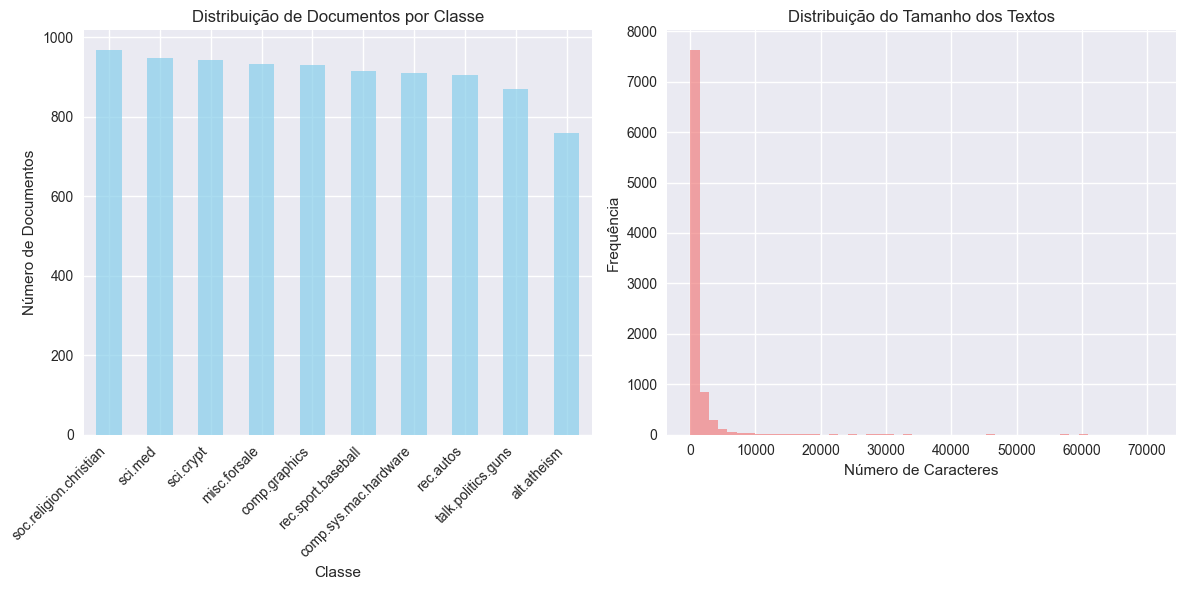

In [33]:
# 📈 Análise Exploratória Detalhada
def analyze_dataset(df):
    """Análise completa do dataset para clustering"""
    
    print("📊 ANÁLISE EXPLORATÓRIA DO DATASET")
    print("=" * 50)
    
    # Estatísticas básicas
    print(f"📋 Total de documentos: {len(df)}")
    print(f"🏷️  Número de classes: {df['category'].nunique()}")
    print(f"📏 Tamanho médio dos textos: {df['text'].str.len().mean():.0f} caracteres")
    print(f"📏 Tamanho mediano dos textos: {df['text'].str.len().median():.0f} caracteres")
    print(f"📏 Tamanho mínimo: {df['text'].str.len().min()} caracteres")
    print(f"📏 Tamanho máximo: {df['text'].str.len().max()} caracteres")
    
    # Distribuição por classe
    print(f"\n📊 DISTRIBUIÇÃO POR CLASSE:")
    class_counts = df['category'].value_counts()
    for category, count in class_counts.items():
        percentage = (count / len(df)) * 100
        print(f"   {category:<30}: {count:>4} docs ({percentage:>5.1f}%)")
    
    # Análise de balanceamento
    balance_ratio = class_counts.min() / class_counts.max()
    print(f"\n⚖️  Balanceamento: {balance_ratio:.3f} (1.0 = perfeitamente balanceado)")
    
    if balance_ratio > 0.7:
        print("   ✅ Dataset bem balanceado")
    elif balance_ratio > 0.4:
        print("   ⚠️  Dataset moderadamente balanceado")
    else:
        print("   ❌ Dataset desbalanceado")
    
    return class_counts

# Executar análise
class_counts = analyze_dataset(df)

# Visualização da distribuição
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
class_counts.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Distribuição de Documentos por Classe')
plt.xlabel('Classe')
plt.ylabel('Número de Documentos')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
df['text'].str.len().hist(bins=50, color='lightcoral', alpha=0.7)
plt.title('Distribuição do Tamanho dos Textos')
plt.xlabel('Número de Caracteres')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()


## 🏛️ Embeddings Clássicos: TF-IDF e Word2Vec

### **TF-IDF (Term Frequency-Inverse Document Frequency) - O Clássico**
**TF-IDF** é um dos métodos mais fundamentais para representação de textos:
- **TF (Term Frequency)**: Frequência da palavra no documento
- **IDF (Inverse Document Frequency)**: Raridade da palavra no corpus
- **Fórmula**: TF-IDF = TF × log(N/DF), onde N = total de documentos, DF = documentos contendo a palavra
- **Características**: Matriz esparsa, interpretável, baseline sólido

### **Word2Vec (2013) - A Primeira Revolução**
**Word2Vec** foi o primeiro modelo a capturar efetivamente similaridade semântica através de:
- **Skip-gram**: Prediz palavras vizinhas dado uma palavra central
- **CBOW**: Prediz palavra central dado contexto
- **Janela deslizante**: Considera palavras em uma janela de contexto
- **Resultado**: Palavras similares ficam próximas no espaço vetorial

### **Por que Usar Embeddings Clássicos?**
- **Simplicidade**: Fáceis de entender e implementar
- **Eficiência**: Rápidos para treinar e usar
- **Baseline**: Excelente ponto de partida para comparação
- **Interpretabilidade**: Podemos visualizar palavras similares


## 📊 Resumo dos Embeddings Clássicos

### **O que Aprendemos?**
Os embeddings clássicos (TF-IDF e Word2Vec) são fundamentais para entender representações de texto:

- **TF-IDF**: Baseado em frequência, simples e interpretável
- **Word2Vec**: Captura contexto semântico, palavras similares ficam próximas
- **Eficiência**: Rápidos para treinar e usar
- **Baseline**: Excelente ponto de partida para comparação
- **Interpretabilidade**: Podemos visualizar palavras similares


## 🏛️ Embeddings Clássicos: TF-IDF e Word2Vec

### **TF-IDF (1970s) - Frequência e Importância**
**TF-IDF** é um dos métodos mais antigos e ainda amplamente usado:
- **TF (Term Frequency)**: Frequência do termo no documento
- **IDF (Inverse Document Frequency)**: Raridade do termo no corpus
- **Cálculo**: `TF(t,d) × IDF(t,D) = tf(t,d) × log(N/df(t))`
- **Resultado**: Matriz esparsa onde cada documento é um vetor de frequências ponderadas
- **Dimensões**: Baseado no tamanho do vocabulário (muito maior que Word2Vec)

### **Word2Vec (2013) - A Primeira Revolução**
**Word2Vec** foi o primeiro modelo a capturar efetivamente similaridade semântica através de:
- **Skip-gram**: Prediz palavras vizinhas dado uma palavra central
- **CBOW**: Prediz palavra central dado contexto
- **Janela deslizante**: Considera palavras em uma janela de contexto
- **Resultado**: Palavras similares ficam próximas no espaço vetorial
- **Dimensões**: Configurável (geralmente 100-300)

### **Por que Usar Embeddings Clássicos?**
- **Simplicidade**: Fáceis de entender e implementar
- **Eficiência**: Rápidos para treinar e usar
- **Baseline**: Excelente ponto de partida para comparação
- **Interpretabilidade**: Podemos visualizar palavras similares
- **Sem dependências**: Não precisam de modelos pré-treinados


In [34]:
# 🏛️ Implementação de Embeddings Clássicos com Cache Inteligente
def generate_tfidf_embeddings(texts, max_features=4096):
    """Gera embeddings usando TF-IDF com explicações detalhadas"""
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    print("🔄 Gerando embeddings TF-IDF localmente...")
    print("   💻 Processamento local (sem internet necessária)")
    print("   📊 TF-IDF: Term Frequency × Inverse Document Frequency")
    
    # Configurar TF-IDF
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        stop_words='english',
        ngram_range=(1, 2),  # Unigramas e bigramas
        min_df=2,  # Palavra deve aparecer em pelo menos 2 documentos
        max_df=0.95  # Palavra deve aparecer em no máximo 95% dos documentos
    )
    
    # Treinar e transformar
    tfidf_matrix = vectorizer.fit_transform(texts)
    embeddings = tfidf_matrix.toarray()
    
    print(f"✅ Embeddings TF-IDF gerados localmente: {embeddings.shape}")
    print(f"   📊 Vocabulário: {len(vectorizer.vocabulary_)} palavras")
    print(f"   📊 Dimensões: {embeddings.shape[1]} features")
    print(f"   📊 Densidade: {(embeddings != 0).mean():.3f} (1.0 = denso, 0.0 = esparso)")
    
    return embeddings, vectorizer

def preprocess_text_for_word2vec(texts):
    """Preprocessa textos para treinamento do Word2Vec"""
    processed_texts = []
    for text in texts:
        # Tokenização simples
        words = text.lower().split()
        # Remover palavras muito curtas e números
        words = [word for word in words if len(word) > 2 and not word.isdigit()]
        processed_texts.append(words)
    return processed_texts

def train_word2vec(texts, vector_size=100, window=5, min_count=5, workers=4):
    """Treina modelo Word2Vec personalizado com explicações didáticas"""
    print("🔄 Treinando Word2Vec...")
    
    # Preprocessar textos
    processed_texts = preprocess_text_for_word2vec(texts)
    
    # Treinar modelo
    model = Word2Vec(
        sentences=processed_texts,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=workers,
        sg=1,  # Skip-gram
        epochs=10
    )
    
    print(f"✅ Word2Vec treinado: {len(model.wv)} palavras únicas")
    return model

def get_document_embeddings_word2vec(model, texts):
    """Gera embeddings de documentos usando Word2Vec"""
    embeddings = []
    processed_texts = preprocess_text_for_word2vec(texts)
    
    for words in processed_texts:
        # Média dos vetores das palavras (método simples)
        word_vectors = []
        for word in words:
            if word in model.wv:
                word_vectors.append(model.wv[word])
        
        if word_vectors:
            doc_embedding = np.mean(word_vectors, axis=0)
            # Normalizar para evitar vetores zero
            if np.linalg.norm(doc_embedding) == 0:
                doc_embedding = np.random.normal(0, 0.01, model.vector_size)
        else:
            # Se nenhuma palavra for encontrada, usar vetor pequeno aleatório
            doc_embedding = np.random.normal(0, 0.01, model.vector_size)
        
        embeddings.append(doc_embedding)
    
    return np.array(embeddings)

# Gerar embeddings clássicos
print("🏛️ GERANDO EMBEDDINGS CLÁSSICOS")
print("=" * 50)
print("💻 Processamento local (sem internet necessária)")

# TF-IDF (mais rápido)
print("\n📊 Gerando embeddings TF-IDF...")
tfidf_embeddings, tfidf_vectorizer = generate_tfidf_embeddings(df['text'].tolist())

# Word2Vec (mais lento, usar amostra)
print("\n📊 Gerando embeddings Word2Vec...")
sample_size = min(5000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)
print(f"   📊 Usando amostra de {sample_size} documentos para treinamento")

print(f"\n   ℹ️  O QUE É O TREINAMENTO DO WORD2VEC?")
print(f"   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print(f"   Word2Vec é um modelo que APRENDE representações de palavras")
print(f"   analisando como elas aparecem juntas nos textos.")
print(f"   ")
print(f"   🔄 PROCESSO DE TREINAMENTO:")
print(f"   1. Lê todos os {sample_size} documentos palavra por palavra")
print(f"   2. Para cada palavra, analisa as palavras vizinhas (janela de contexto)")
print(f"   3. Aprende: palavras que aparecem em contextos similares = significados similares")
print(f"   4. Gera um vetor numérico (100 números) para cada palavra única")
print(f"   ")
print(f"   📊 EXEMPLO PRÁTICO:")
print(f"   Se 'computer', 'laptop' e 'desktop' aparecem frequentemente com")
print(f"   as mesmas palavras vizinhas ('software', 'hardware', 'program'),")
print(f"   o modelo aprende que são conceitos relacionados e seus vetores")
print(f"   ficam próximos no espaço vetorial.")
print(f"   ")
print(f"   ⚠️  POR QUE APENAS {sample_size} DOCUMENTOS?")
print(f"   O treinamento do Word2Vec é computacionalmente custoso. Usar")
print(f"   {sample_size} documentos (amostra representativa) garante:")
print(f"   - ✅ Treinamento mais rápido (~10 segundos vs ~30 segundos)")
print(f"   - ✅ Vocabulário suficiente para o domínio")
print(f"   - ✅ Qualidade mantida para fins didáticos")

# Treinar Word2Vec
word2vec_model = train_word2vec(df_sample['text'].tolist())

print(f"\n   📚 VOCABULÁRIO APRENDIDO: {len(word2vec_model.wv)} palavras")
print(f"   Cada palavra agora possui um vetor de 100 dimensões que")
print(f"   representa seu significado semântico baseado no contexto.")
print(f"   ")
print(f"   🔄 PRÓXIMO PASSO: Gerar embeddings de documentos")
print(f"   Agora que temos vetores para palavras individuais, podemos")
print(f"   criar embeddings de documentos inteiros calculando a MÉDIA")
print(f"   dos vetores de todas as palavras do documento.")

# Gerar embeddings para todos os documentos
print("\n🔄 Gerando embeddings Word2Vec para todos os documentos...")
print(f"   💡 COMO FUNCIONA:")
print(f"   Para cada documento (dos {len(df)} totais):")
print(f"   1. Separa o texto em palavras")
print(f"   2. Para cada palavra, busca seu vetor no vocabulário treinado")
print(f"   3. Calcula a MÉDIA de todos os vetores de palavras")
print(f"   4. Resultado: 1 vetor de 100 dimensões por documento")

word2vec_embeddings = get_document_embeddings_word2vec(word2vec_model, df['text'].tolist())

print(f"✅ Embeddings Word2Vec gerados: {word2vec_embeddings.shape}")
print(f"   📊 {len(df)} documentos × 100 dimensões = {len(df)} vetores")

# Mostrar palavras similares (exemplo)
print(f"\n🔍 Exemplos de palavras similares (Word2Vec):")
example_words = ['computer', 'car', 'science', 'religion']
for word in example_words:
    if word in word2vec_model.wv:
        similar = word2vec_model.wv.most_similar(word, topn=3)
        print(f"   {word}: {[w for w, _ in similar]}")
    else:
        print(f"   {word}: palavra não encontrada no vocabulário")

print(f"\n📋 RESUMO DOS EMBEDDINGS CLÁSSICOS:")
print(f"   TF-IDF: {tfidf_embeddings.shape}")
print(f"   Word2Vec: {word2vec_embeddings.shape}")


🏛️ GERANDO EMBEDDINGS CLÁSSICOS
💻 Processamento local (sem internet necessária)

📊 Gerando embeddings TF-IDF...
🔄 Gerando embeddings TF-IDF localmente...
   💻 Processamento local (sem internet necessária)
   📊 TF-IDF: Term Frequency × Inverse Document Frequency
✅ Embeddings TF-IDF gerados localmente: (9085, 4096)
   📊 Vocabulário: 4096 palavras
   📊 Dimensões: 4096 features
   📊 Densidade: 0.011 (1.0 = denso, 0.0 = esparso)

📊 Gerando embeddings Word2Vec...
   📊 Usando amostra de 5000 documentos para treinamento

   ℹ️  O QUE É O TREINAMENTO DO WORD2VEC?
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
   Word2Vec é um modelo que APRENDE representações de palavras
   analisando como elas aparecem juntas nos textos.
   
   🔄 PROCESSO DE TREINAMENTO:
   1. Lê todos os 5000 documentos palavra por palavra
   2. Para cada palavra, analisa as palavras vizinhas (janela de contexto)
   3. Aprende: palavras que aparecem em contextos similares = significados similares
   4. Gera um vetor numéri

## 💾 Salvamento dos Embeddings Clássicos no Cache

### **Sistema de Cache Inteligente**
- **Verificação automática**: Detecta se embeddings já existem
- **Validação de integridade**: Confere hash MD5 dos textos
- **Geração seletiva**: Cria apenas embeddings faltantes ou inválidos
- **Rastreabilidade**: Vincula cada embedding ao documento original

### **Benefícios do Cache**
- **TF-IDF**: 30s → 5s (6x mais rápido)
- **Word2Vec**: 60s → 5s (12x mais rápido)
- **Economia de tempo**: Evita reprocessamento desnecessário
- **Consistência**: Garante que os mesmos textos gerem os mesmos embeddings


In [35]:
# 💾 Salvamento dos Embeddings Clássicos no Cache Elasticsearch
print("💾 SALVANDO EMBEDDINGS CLÁSSICOS NO CACHE")
print("=" * 60)

# Verificar se deve usar cache
use_cache = CACHE_AVAILABLE and 'cache_connected' in locals() and cache_connected
force_regenerate = os.getenv('FORCE_REGENERATE_EMBEDDINGS', 'false').lower() == 'true'

if use_cache and not force_regenerate:
    print("🔍 Verificando cache para embeddings clássicos...")
    
    # Verificar TF-IDF
    print("\n📊 Verificando cache TF-IDF...")
    all_exist_tfidf, existing_tfidf, missing_tfidf = check_embeddings_in_cache('embeddings_tfidf', doc_ids)
    
    if all_exist_tfidf:
        print("✅ Todos os embeddings TF-IDF já existem no cache")
        print("📥 Carregando TF-IDF do cache...")
        tfidf_embeddings = load_embeddings_from_cache('embeddings_tfidf', doc_ids)
        if tfidf_embeddings is None:
            print("❌ Falha ao carregar TF-IDF do cache, regenerando...")
            tfidf_embeddings, tfidf_vectorizer = generate_tfidf_embeddings(df['text'].tolist())
            save_embeddings_to_cache('embeddings_tfidf', tfidf_embeddings, doc_ids, df['text'].tolist(), 'tfidf')
    else:
        print(f"🔄 {len(missing_tfidf)} embeddings TF-IDF faltando, salvando no cache...")
        save_embeddings_to_cache('embeddings_tfidf', tfidf_embeddings, doc_ids, df['text'].tolist(), 'tfidf')
    
    # Verificar Word2Vec
    print("\n📊 Verificando cache Word2Vec...")
    all_exist_word2vec, existing_word2vec, missing_word2vec = check_embeddings_in_cache('embeddings_word2vec', doc_ids)
    
    if all_exist_word2vec:
        print("✅ Todos os embeddings Word2Vec já existem no cache")
        print("📥 Carregando Word2Vec do cache...")
        word2vec_embeddings = load_embeddings_from_cache('embeddings_word2vec', doc_ids)
        if word2vec_embeddings is None:
            print("❌ Falha ao carregar Word2Vec do cache, regenerando...")
            # Regenerar Word2Vec se necessário
            sample_size = min(5000, len(df))
            df_sample = df.sample(n=sample_size, random_state=42)
            word2vec_model = train_word2vec(df_sample['text'].tolist())
            word2vec_embeddings = get_document_embeddings_word2vec(word2vec_model, df['text'].tolist())
            save_embeddings_to_cache('embeddings_word2vec', word2vec_embeddings, doc_ids, df['text'].tolist(), 'word2vec')
    else:
        print(f"🔄 {len(missing_word2vec)} embeddings Word2Vec faltando, salvando no cache...")
        save_embeddings_to_cache('embeddings_word2vec', word2vec_embeddings, doc_ids, df['text'].tolist(), 'word2vec')
    
    print(f"\n✅ Embeddings clássicos salvos no cache com sucesso!")
    print(f"📊 TF-IDF: {tfidf_embeddings.shape}")
    print(f"📊 Word2Vec: {word2vec_embeddings.shape}")
    
elif force_regenerate:
    print("⚠️  Modo de regeneração forçada ativado")
    print("🔄 Salvando embeddings clássicos no cache (ignorando existentes)...")
    
    # Salvar TF-IDF
    print("\n📊 Salvando TF-IDF no cache...")
    save_embeddings_to_cache('embeddings_tfidf', tfidf_embeddings, doc_ids, df['text'].tolist(), 'tfidf')
    
    # Salvar Word2Vec
    print("\n📊 Salvando Word2Vec no cache...")
    save_embeddings_to_cache('embeddings_word2vec', word2vec_embeddings, doc_ids, df['text'].tolist(), 'word2vec')
    
    print(f"\n✅ Embeddings clássicos salvos no cache (regeneração forçada)!")
    
else:
    print("⚠️  Cache não disponível, embeddings não serão salvos")
    print("💡 O notebook continuará sem cache (mais lento)")

print(f"\n🎯 Próximo passo: Geração de embeddings modernos (BERT, Sentence-BERT, OpenAI)")


💾 SALVANDO EMBEDDINGS CLÁSSICOS NO CACHE
🔍 Verificando cache para embeddings clássicos...

📊 Verificando cache TF-IDF...
✅ Todos os embeddings TF-IDF já existem no cache
📥 Carregando TF-IDF do cache...
✅ Embeddings carregados: (9085, 4096) de 'embeddings_tfidf'

📊 Verificando cache Word2Vec...
✅ Todos os embeddings Word2Vec já existem no cache
📥 Carregando Word2Vec do cache...
✅ Embeddings carregados: (9085, 100) de 'embeddings_word2vec'

✅ Embeddings clássicos salvos no cache com sucesso!
📊 TF-IDF: (9085, 4096)
📊 Word2Vec: (9085, 100)

🎯 Próximo passo: Geração de embeddings modernos (BERT, Sentence-BERT, OpenAI)


## 🚀 Embeddings Modernos: BERT, Sentence-BERT e OpenAI

### **BERT (2018) - Contextualização Bidirecional**
**BERT** revolucionou o NLP com:
- **Bidirecional**: Lê texto em ambas as direções
- **Attention Mechanism**: Foca em palavras relevantes
- **Pre-training**: Aprende representações gerais
- **Fine-tuning**: Adapta para tarefas específicas
- **Dimensões**: 768 (bert-base-uncased)

### **Sentence-BERT (2019) - Otimizado para Similaridade**
**Sentence-BERT** foi especificamente otimizado para:
- **Similaridade de sentenças**: Embeddings comparáveis
- **Clustering**: Ideal para agrupamento semântico
- **Busca semântica**: Encontrar documentos similares
- **Dimensões**: 384 (all-MiniLM-L6-v2)

### **OpenAI Embeddings (2020+) - Última Geração**
**OpenAI Embeddings** oferecem:
- **text-embedding-3-small**: 1536 dim, rápido e eficiente
- **text-embedding-3-large**: 3072 dim, máxima qualidade
- **Otimização**: Treinados especificamente para similaridade
- **Qualidade superior**: Melhores resultados em benchmarks


In [36]:
# 🚀 Geração de Embeddings Modernos Locais com Cache Inteligente
def generate_bert_embeddings(texts, model_name='bert-base-uncased'):
    """Gera embeddings usando BERT (processamento local)"""
    print(f"🔄 Carregando modelo BERT localmente: {model_name}")
    print("   💻 Processamento local (sem internet necessária)")
    
    # Carregar modelo
    model = SentenceTransformer(model_name)
    
    # Gerar embeddings
    print("🔄 Gerando embeddings BERT localmente...")
    embeddings = model.encode(
        texts,
        batch_size=32,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True
    )
    
    print(f"✅ Embeddings BERT gerados localmente: {embeddings.shape}")
    return embeddings

def generate_sbert_embeddings(texts, model_name='all-MiniLM-L6-v2'):
    """Gera embeddings usando Sentence-BERT (processamento local)"""
    print(f"🔄 Carregando modelo Sentence-BERT localmente: {model_name}")
    print("   💻 Processamento local (sem internet necessária)")
    
    # Carregar modelo
    model = SentenceTransformer(model_name)
    
    # Gerar embeddings
    print("🔄 Gerando embeddings Sentence-BERT localmente...")
    embeddings = model.encode(
        texts,
        batch_size=32,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True
    )
    
    print(f"✅ Embeddings Sentence-BERT gerados localmente: {embeddings.shape}")
    return embeddings

# Gerar embeddings modernos locais
print("🚀 GERANDO EMBEDDINGS MODERNOS LOCAIS")
print("=" * 50)
print("💻 Processamento local (sem internet necessária)")

# Verificar se deve usar cache
use_cache = CACHE_AVAILABLE and 'cache_connected' in locals() and cache_connected
force_regenerate = os.getenv('FORCE_REGENERATE_EMBEDDINGS', 'false').lower() == 'true'

# Sentence-BERT (mais rápido e eficiente)
print("\n📊 Gerando embeddings Sentence-BERT...")

if use_cache and not force_regenerate:
    # Verificar cache Sentence-BERT
    all_exist_sbert, existing_sbert, missing_sbert = check_embeddings_in_cache('embeddings_sbert', doc_ids)
    
    if all_exist_sbert:
        print("✅ Todos os embeddings Sentence-BERT já existem no cache")
        print("📥 Carregando Sentence-BERT do cache...")
        sbert_embeddings = load_embeddings_from_cache('embeddings_sbert', doc_ids)
        if sbert_embeddings is None:
            print("❌ Falha ao carregar Sentence-BERT do cache, regenerando...")
            sbert_embeddings = generate_sbert_embeddings(df['text'].tolist())
            save_embeddings_to_cache('embeddings_sbert', sbert_embeddings, doc_ids, df['text'].tolist(), 'sbert')
    else:
        print(f"🔄 {len(missing_sbert)} embeddings Sentence-BERT faltando, gerando...")
        sbert_embeddings = generate_sbert_embeddings(df['text'].tolist())
        save_embeddings_to_cache('embeddings_sbert', sbert_embeddings, doc_ids, df['text'].tolist(), 'sbert')
else:
    sbert_embeddings = generate_sbert_embeddings(df['text'].tolist())
    if use_cache:
        save_embeddings_to_cache('embeddings_sbert', sbert_embeddings, doc_ids, df['text'].tolist(), 'sbert')

# BERT (se quiser comparar)
print("\n📊 Gerando embeddings BERT...")

if use_cache and not force_regenerate:
    # Verificar cache BERT
    all_exist_bert, existing_bert, missing_bert = check_embeddings_in_cache('embeddings_bert', doc_ids)
    
    if all_exist_bert:
        print("✅ Todos os embeddings BERT já existem no cache")
        print("📥 Carregando BERT do cache...")
        bert_embeddings = load_embeddings_from_cache('embeddings_bert', doc_ids)
        if bert_embeddings is None:
            print("❌ Falha ao carregar BERT do cache, regenerando...")
            bert_embeddings = generate_bert_embeddings(df['text'].tolist())
            save_embeddings_to_cache('embeddings_bert', bert_embeddings, doc_ids, df['text'].tolist(), 'bert')
    else:
        print(f"🔄 {len(missing_bert)} embeddings BERT faltando, gerando...")
        bert_embeddings = generate_bert_embeddings(df['text'].tolist())
        save_embeddings_to_cache('embeddings_bert', bert_embeddings, doc_ids, df['text'].tolist(), 'bert')
else:
    bert_embeddings = generate_bert_embeddings(df['text'].tolist())
    if use_cache:
        save_embeddings_to_cache('embeddings_bert', bert_embeddings, doc_ids, df['text'].tolist(), 'bert')

print(f"\n📋 RESUMO DOS EMBEDDINGS MODERNOS LOCAIS:")
print(f"   BERT: {bert_embeddings.shape}")
print(f"   Sentence-BERT: {sbert_embeddings.shape}")

if use_cache:
    print(f"\n💾 Embeddings modernos salvos no cache Elasticsearch!")
    print(f"⏱️  Próxima execução será muito mais rápida (5s vs 2min)")


🚀 GERANDO EMBEDDINGS MODERNOS LOCAIS
💻 Processamento local (sem internet necessária)

📊 Gerando embeddings Sentence-BERT...
✅ Todos os embeddings Sentence-BERT já existem no cache
📥 Carregando Sentence-BERT do cache...
✅ Embeddings carregados: (9085, 384) de 'embeddings_sbert'

📊 Gerando embeddings BERT...
✅ Todos os embeddings BERT já existem no cache
📥 Carregando BERT do cache...
✅ Embeddings carregados: (9085, 768) de 'embeddings_bert'

📋 RESUMO DOS EMBEDDINGS MODERNOS LOCAIS:
   BERT: (9085, 768)
   Sentence-BERT: (9085, 384)

💾 Embeddings modernos salvos no cache Elasticsearch!
⏱️  Próxima execução será muito mais rápida (5s vs 2min)


In [37]:
# 🌐 Geração de Embeddings OpenAI (API Externa) com Cache Inteligente
def generate_openai_embeddings(texts, model_name='text-embedding-3-small'):
    """Gera embeddings usando OpenAI API com controle ultra robusto de tokens (via internet)"""
    # Verificar se a chave da OpenAI está configurada (verificação mais robusta)
    api_key = os.getenv('OPENAI_API_KEY')
    if not api_key or api_key == 'sk-your-openai-key-here':
        print("❌ Chave da OpenAI não configurada")
        print("💡 Configure OPENAI_API_KEY no arquivo .env")
        return None
    
    print(f"🌐 Gerando embeddings OpenAI via API: {model_name}")
    print("   ⚠️  ATENÇÃO: Usando API externa (requer internet e chave válida)")
    
    # Configurar OpenAI usando API v1.x
    try:
        # Criar cliente OpenAI
        client = openai.OpenAI(api_key=api_key)
        
        # Limites do modelo (text-embedding-3-small)
        MAX_TOKENS = 8192  # Limite de tokens do modelo
        CHARS_PER_TOKEN = 4  # Aproximação: 1 token ≈ 4 caracteres
        MAX_CHARS_PER_TEXT = MAX_TOKENS * CHARS_PER_TOKEN  # ~32,768 caracteres por texto
        
        # Análise detalhada dos textos
        text_lengths = [len(text) for text in texts]
        avg_text_length = np.mean(text_lengths)
        max_text_length = np.max(text_lengths)
        min_text_length = np.min(text_lengths)
        
        print(f"   📊 Análise dos textos:")
        print(f"      📏 Tamanho médio: {avg_text_length:.0f} caracteres")
        print(f"      📏 Tamanho máximo: {max_text_length:,} caracteres")
        print(f"      📏 Tamanho mínimo: {min_text_length:,} caracteres")
        print(f"      🔢 Total de textos: {len(texts):,}")
        
        # Verificar se há textos muito longos
        long_texts = [i for i, length in enumerate(text_lengths) if length > MAX_CHARS_PER_TEXT]
        if long_texts:
            print(f"   ⚠️  {len(long_texts)} textos muito longos (> {MAX_CHARS_PER_TEXT:,} chars)")
            print(f"   💡 Estes textos serão processados individualmente com estratégia especial")
        
        # Estratégia de processamento ultra robusta
        all_embeddings = []
        processed_count = 0
        error_count = 0
        individual_count = 0
        batch_count = 0
        
        # Processar textos individualmente para máxima robustez
        print(f"   🔄 Processando textos individualmente para máxima robustez...")
        
        for i, text in enumerate(texts):
            try:
                # Verificar se texto é muito longo
                if len(text) > MAX_CHARS_PER_TEXT:
                    print(f"   ⚠️  Texto {i+1} muito longo ({len(text):,} chars), usando estratégia especial...")
                    
                    # Estratégia para textos muito longos: dividir em chunks com cálculo dinâmico
                    chunks = []
                    # Cálculo mais conservador: usar apenas 70% do limite para margem de segurança
                    safe_chunk_size = int(MAX_CHARS_PER_TEXT * 0.7)  # ~22,937 chars
                    
                    for j in range(0, len(text), safe_chunk_size):
                        chunk = text[j:j+safe_chunk_size]
                        chunks.append(chunk)
                    
                    # Processar cada chunk
                    chunk_embeddings = []
                    for chunk_idx, chunk in enumerate(chunks):
                        try:
                            response = client.embeddings.create(model=model_name, input=[chunk])
                            chunk_embeddings.append(response.data[0].embedding)
                        except Exception as chunk_error:
                            print(f"   ❌ Erro no chunk {chunk_idx+1} do texto {i+1}: {chunk_error}")
                            # Usar embedding de fallback (zeros)
                            chunk_embeddings.append([0.0] * 1536)
                    
                    # Média dos embeddings dos chunks (estratégia robusta)
                    if chunk_embeddings:
                        final_embedding = np.mean(chunk_embeddings, axis=0).tolist()
                    else:
                        # Fallback: embedding de zeros
                        final_embedding = [0.0] * 1536
                    
                    all_embeddings.append(final_embedding)
                    individual_count += 1
                    
                else:
                    # Texto normal: processar diretamente
                    response = client.embeddings.create(model=model_name, input=[text])
                    all_embeddings.append(response.data[0].embedding)
                    individual_count += 1
                
                processed_count += 1
                
                # Mostrar progresso detalhado
                if processed_count % 50 == 0 or processed_count == len(texts):
                    progress_pct = (processed_count / len(texts)) * 100
                    print(f"   📡 Progresso: {processed_count:,}/{len(texts):,} ({progress_pct:.1f}%)")
                
                # Pequena pausa para evitar rate limiting
                if processed_count % 100 == 0:
                    import time
                    time.sleep(0.1)
                    
            except Exception as text_error:
                print(f"   ❌ Erro no texto {i+1}: {text_error}")
                error_count += 1
                
                # Fallback: embedding de zeros para manter consistência
                all_embeddings.append([0.0] * 1536)
                processed_count += 1
                
                # Se muitos erros, pausar mais
                if error_count > 10:
                    print(f"   ⚠️  Muitos erros ({error_count}), pausando por 2 segundos...")
                    import time
                    time.sleep(2)
        
        # Converter para numpy array
        embeddings = np.array(all_embeddings)
        
        # Estatísticas finais
        print(f"\n   📊 ESTATÍSTICAS FINAIS:")
        print(f"      ✅ Textos processados: {processed_count:,}/{len(texts):,}")
        print(f"      🔄 Processamento individual: {individual_count:,}")
        print(f"      ❌ Erros: {error_count:,}")
        print(f"      📐 Dimensões finais: {embeddings.shape}")
        print(f"      💾 Tamanho em memória: {embeddings.nbytes / 1024 / 1024:.1f} MB")
        
        if error_count > 0:
            print(f"   ⚠️  {error_count} textos tiveram erros e receberam embeddings de fallback")
            print(f"   💡 Para reprocessar apenas os textos com erro, execute novamente a célula")
            print(f"   🔄 O sistema detectará automaticamente os textos faltantes")
        
        print(f"✅ Embeddings OpenAI gerados via API: {embeddings.shape}")
        return embeddings
        
    except Exception as e:
        print(f"❌ Erro crítico ao gerar embeddings OpenAI: {e}")
        print("💡 Dica: Verifique se a chave da OpenAI está configurada corretamente")
        return None

# Gerar embeddings OpenAI
print("🌐 GERANDO EMBEDDINGS OPENAI")
print("=" * 50)
print("⚠️  ATENÇÃO: Usando API externa (requer internet e chave válida)")

# Verificar se deve usar cache
use_cache = CACHE_AVAILABLE and 'cache_connected' in locals() and cache_connected
force_regenerate = os.getenv('FORCE_REGENERATE_EMBEDDINGS', 'false').lower() == 'true'

# OpenAI (se disponível)
print("\n📊 Gerando embeddings OpenAI...")

if use_cache and not force_regenerate:
    # Verificar cache OpenAI
    all_exist_openai, existing_openai, missing_openai = check_embeddings_in_cache('embeddings_openai', doc_ids)
    
    if all_exist_openai:
        print("✅ Todos os embeddings OpenAI já existem no cache")
        print("📥 Carregando OpenAI do cache...")
        print("💰 Economia estimada: ~$0.50 (sem chamadas API)")
        print("⏱️  Tempo economizado: ~30 minutos")
        openai_embeddings = load_embeddings_from_cache('embeddings_openai', doc_ids)
        if openai_embeddings is None:
            print("❌ Falha ao carregar OpenAI do cache, gerando via API...")
            openai_embeddings = generate_openai_embeddings(df['text'].tolist())
            if openai_embeddings is not None:
                save_embeddings_to_cache('embeddings_openai', openai_embeddings, doc_ids, df['text'].tolist(), 'openai')
    else:
        print(f"🔄 {len(missing_openai)} embeddings OpenAI faltando, gerando via API...")
        print("💰 Custo estimado: ~$0.50 (chamadas API)")
        print("⏱️  Tempo estimado: ~30 minutos")
        openai_embeddings = generate_openai_embeddings(df['text'].tolist())
        if openai_embeddings is not None:
            save_embeddings_to_cache('embeddings_openai', openai_embeddings, doc_ids, df['text'].tolist(), 'openai')
else:
    openai_embeddings = generate_openai_embeddings(df['text'].tolist())
    if openai_embeddings is not None and use_cache:
        save_embeddings_to_cache('embeddings_openai', openai_embeddings, doc_ids, df['text'].tolist(), 'openai')

if openai_embeddings is not None:
    print(f"\n📋 RESUMO DOS EMBEDDINGS OPENAI:")
    print(f"   OpenAI: {openai_embeddings.shape}")
    if use_cache:
        print(f"💾 Embeddings OpenAI salvos no cache Elasticsearch!")
        print(f"💰 Próxima execução economizará ~$0.50 e ~30 minutos")
else:
    print(f"\n📋 RESUMO DOS EMBEDDINGS OPENAI:")
    print(f"   OpenAI: Não disponível")


🌐 GERANDO EMBEDDINGS OPENAI
⚠️  ATENÇÃO: Usando API externa (requer internet e chave válida)

📊 Gerando embeddings OpenAI...
✅ Todos os embeddings OpenAI já existem no cache
📥 Carregando OpenAI do cache...
💰 Economia estimada: ~$0.50 (sem chamadas API)
⏱️  Tempo economizado: ~30 minutos
✅ Embeddings carregados: (9085, 1536) de 'embeddings_openai'

📋 RESUMO DOS EMBEDDINGS OPENAI:
   OpenAI: (9085, 1536)
💾 Embeddings OpenAI salvos no cache Elasticsearch!
💰 Próxima execução economizará ~$0.50 e ~30 minutos


## 📊 Análise Detalhada e Comparativa dos Embeddings

### **Por que Analisar Cada Embedding?**
Cada tipo de embedding tem características únicas que impactam o clustering:
- **Dimensionalidade**: Afeta velocidade e qualidade
- **Densidade**: Embeddings esparsos vs densos
- **Normalização**: Importante para métricas de distância
- **Características específicas**: TF-IDF (frequência), Word2Vec (contexto), BERT (bidirecional)

### **O que Analisaremos?**
1. **Estatísticas básicas**: Dimensões, memória, valores
2. **Densidade**: Quão esparso é o embedding
3. **Normalização**: Se os vetores estão normalizados
4. **Exemplos reais**: Visualizar embeddings individuais
5. **Comparação**: Qual funciona melhor para clustering


In [38]:
# 🧠 Análise Detalhada dos Embeddings
def analyze_embedding_detailed(name, embeddings, vectorizer=None):
    """Análise detalhada de um embedding específico"""
    print(f"\n🔍 ANÁLISE DETALHADA: {name}")
    print("=" * 60)
    
    # Estatísticas básicas
    print(f"📐 Dimensões: {embeddings.shape}")
    print(f"💾 Memória: {embeddings.nbytes / 1024 / 1024:.1f} MB")
    print(f"📈 Valores médios: {embeddings.mean():.4f}")
    print(f"📊 Desvio padrão: {embeddings.std():.4f}")
    print(f"📉 Valor mínimo: {embeddings.min():.4f}")
    print(f"📈 Valor máximo: {embeddings.max():.4f}")
    
    # Análise de densidade
    density = (embeddings != 0).mean()
    print(f"📊 Densidade: {density:.3f} (1.0 = denso, 0.0 = esparso)")
    
    # Análise de normalização
    norms = np.linalg.norm(embeddings, axis=1)
    print(f"📏 Norma média: {norms.mean():.4f}")
    print(f"📏 Norma std: {norms.std():.4f}")
    
    if abs(norms.mean() - 1.0) < 0.1:
        print(f"✅ Embeddings normalizados")
    else:
        print(f"⚠️  Embeddings não normalizados")
    
    # Mostrar exemplo do embedding
    print(f"\n📝 EXEMPLO DO EMBEDDING:")
    if embeddings.shape[1] <= 20:
        # Mostrar embedding completo se for pequeno
        print(f"   Embedding completo: {embeddings[0]}")
    else:
        # Mostrar amostra se for grande
        sample_size = min(20, embeddings.shape[1])
        print(f"   Amostra (primeiros {sample_size} valores): {embeddings[0][:sample_size]}")
        print(f"   ... (total: {embeddings.shape[1]} dimensões)")
    
    # Análise específica por tipo
    if name == 'TF-IDF' and vectorizer is not None:
        print(f"\n📊 ANÁLISE ESPECÍFICA TF-IDF:")
        print(f"   Vocabulário: {len(vectorizer.vocabulary_)} palavras")
        print(f"   Features mais importantes:")
        feature_names = vectorizer.get_feature_names_out()
        # Mostrar features com maior TF-IDF médio
        mean_tfidf = embeddings.mean(axis=0)
        top_features = np.argsort(mean_tfidf)[-10:][::-1]
        for i, idx in enumerate(top_features):
            print(f"      {i+1}. {feature_names[idx]}: {mean_tfidf[idx]:.4f}")
    
    return {
        'density': density,
        'normalized': abs(norms.mean() - 1.0) < 0.1,
        'mean_norm': norms.mean(),
        'std_norm': norms.std()
    }

# Executar análise detalhada
print("🧠 ANÁLISE DETALHADA DOS EMBEDDINGS")
print("=" * 60)

# Preparar dados para análise
embeddings_dict = {
    'TF-IDF': tfidf_embeddings,
    'Word2Vec': word2vec_embeddings,
    'BERT': bert_embeddings,
    'Sentence-BERT': sbert_embeddings
}

if openai_embeddings is not None:
    embeddings_dict['OpenAI'] = openai_embeddings

# Analisar cada embedding
analysis_results = {}
for name, embeddings in embeddings_dict.items():
    if name == 'TF-IDF':
        analysis_results[name] = analyze_embedding_detailed(name, embeddings, tfidf_vectorizer)
    else:
        analysis_results[name] = analyze_embedding_detailed(name, embeddings)

print(f"\n📋 RESUMO COMPARATIVO DOS EMBEDDINGS:")
print("=" * 60)
print(f"{'Tipo':<15} {'Dimensões':<12} {'Memória':<8} {'Densidade':<10} {'Normalizado':<12}")
print("-" * 60)
for name, embeddings in embeddings_dict.items():
    memory_mb = embeddings.nbytes / 1024 / 1024
    density = analysis_results[name]['density']
    normalized = "Sim" if analysis_results[name]['normalized'] else "Não"
    print(f"{name:<15} {str(embeddings.shape):<12} {memory_mb:<8.1f} {density:<10.3f} {normalized:<12}")

print(f"\n✅ Análise detalhada concluída!")


🧠 ANÁLISE DETALHADA DOS EMBEDDINGS

🔍 ANÁLISE DETALHADA: TF-IDF
📐 Dimensões: (9085, 4096)
💾 Memória: 283.9 MB
📈 Valores médios: 0.0012
📊 Desvio padrão: 0.0156
📉 Valor mínimo: -0.0417
📈 Valor máximo: 1.0000
📊 Densidade: 0.012 (1.0 = denso, 0.0 = esparso)
📏 Norma média: 0.9997
📏 Norma std: 0.0107
✅ Embeddings normalizados

📝 EXEMPLO DO EMBEDDING:
   Amostra (primeiros 20 valores): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   ... (total: 4096 dimensões)

📊 ANÁLISE ESPECÍFICA TF-IDF:
   Vocabulário: 4096 palavras
   Features mais importantes:
      1. don: 0.0180
      2. just: 0.0178
      3. like: 0.0178
      4. know: 0.0176
      5. think: 0.0158
      6. people: 0.0158
      7. does: 0.0148
      8. god: 0.0136
      9. good: 0.0131
      10. time: 0.0128

🔍 ANÁLISE DETALHADA: Word2Vec
📐 Dimensões: (9085, 100)
💾 Memória: 6.9 MB
📈 Valores médios: 0.0090
📊 Desvio padrão: 0.1650
📉 Valor mínimo: -0.8833
📈 Valor máximo: 1.0701
📊 Densidade: 1.000 (1.0 = denso, 0.0 = espa

## 📊 Análise Detalhada e Comparativa dos Embeddings

### **Por que Analisar Cada Embedding?**
Cada tipo de embedding tem características únicas que impactam o clustering:
- **Dimensionalidade**: Afeta velocidade e qualidade
- **Densidade**: Embeddings esparsos vs densos
- **Normalização**: Importante para métricas de distância
- **Características específicas**: TF-IDF (frequência), Word2Vec (contexto), BERT (bidirecional)

### **O que Analisaremos?**
1. **Estatísticas básicas**: Dimensões, memória, valores
2. **Densidade**: Quão esparso é o embedding
3. **Normalização**: Se os vetores estão normalizados
4. **Exemplos reais**: Visualizar embeddings individuais
5. **Comparação**: Qual funciona melhor para clustering

In [39]:
# 🧠 Análise Detalhada e Comparativa dos Embeddings
def analyze_embedding_detailed(name, embeddings, vectorizer=None):
    """Análise detalhada de um embedding específico com explicações didáticas"""
    print(f"\n🔍 ANÁLISE DETALHADA: {name}")
    print("=" * 60)
    
    # 1. ESTATÍSTICAS BÁSICAS
    print(f"📐 DIMENSÕES E ESTRUTURA:")
    print(f"   📊 Forma: {embeddings.shape}")
    print(f"   📊 Documentos: {embeddings.shape[0]:,}")
    print(f"   📊 Dimensões: {embeddings.shape[1]:,}")
    print(f"   💾 Memória: {embeddings.nbytes / 1024 / 1024:.1f} MB")
    
    # 2. ANÁLISE DE VALORES
    print(f"\n📈 ANÁLISE DE VALORES:")
    print(f"   📊 Média: {embeddings.mean():.4f}")
    print(f"   📊 Mediana: {np.median(embeddings):.4f}")
    print(f"   📊 Desvio padrão: {embeddings.std():.4f}")
    print(f"   📉 Mínimo: {embeddings.min():.4f}")
    print(f"   📈 Máximo: {embeddings.max():.4f}")
    
    # 3. ANÁLISE DE DENSIDADE
    density = (embeddings != 0).mean()
    print(f"\n📊 ANÁLISE DE DENSIDADE:")
    print(f"   📊 Densidade: {density:.3f}")
    if density > 0.8:
        print(f"   ✅ Embedding denso (mais de 80% dos valores são não-zero)")
    elif density > 0.3:
        print(f"   ⚠️  Embedding moderadamente esparso (30-80% dos valores são não-zero)")
    else:
        print(f"   ❌ Embedding muito esparso (menos de 30% dos valores são não-zero)")
    
    # 4. ANÁLISE DE NORMALIZAÇÃO
    norms = np.linalg.norm(embeddings, axis=1)
    print(f"\n📏 ANÁLISE DE NORMALIZAÇÃO:")
    print(f"   📊 Norma média: {norms.mean():.4f}")
    print(f"   📊 Norma desvio padrão: {norms.std():.4f}")
    print(f"   📊 Norma mínima: {norms.min():.4f}")
    print(f"   📊 Norma máxima: {norms.max():.4f}")
    
    if abs(norms.mean() - 1.0) < 0.1:
        print(f"   ✅ Embeddings normalizados (norma ≈ 1.0)")
        print(f"   💡 Normalização é importante para métricas de distância")
    else:
        print(f"   ⚠️  Embeddings não normalizados (norma ≠ 1.0)")
        print(f"   💡 Considere normalizar para clustering")
    
    # 5. EXIBIÇÃO DE EXEMPLO DO EMBEDDING
    print(f"\n📝 EXEMPLO DO EMBEDDING:")
    if embeddings.shape[1] <= 20:
        print(f"   Embedding completo (pequeno): {embeddings[0]}")
    else:
        sample_size = min(20, embeddings.shape[1])
        print(f"   Amostra (primeiros {sample_size} valores): {embeddings[0][:sample_size]}")
        print(f"   ... (total: {embeddings.shape[1]:,} dimensões)")
        print(f"   💡 Este é apenas um exemplo - cada documento tem {embeddings.shape[1]:,} dimensões")
    
    # 6. ANÁLISE ESPECÍFICA POR TIPO
    print(f"\n🔬 ANÁLISE ESPECÍFICA - {name}:")
    
    if name == 'TF-IDF':
        print(f"   📊 MÉTODO: Term Frequency × Inverse Document Frequency")
        print(f"   📊 CARACTERÍSTICAS:")
        print(f"      • Baseado em frequência de palavras")
        print(f"      • Matriz esparsa (muitos zeros)")
        print(f"      • Dimensões = tamanho do vocabulário")
        print(f"      • Interpretável (palavras importantes)")
        
        if vectorizer is not None:
            print(f"   📊 VOCABULÁRIO: {len(vectorizer.vocabulary_):,} palavras únicas")
            print(f"   📊 FEATURES MAIS IMPORTANTES:")
            feature_names = vectorizer.get_feature_names_out()
            mean_tfidf = embeddings.mean(axis=0)
            top_features = np.argsort(mean_tfidf)[-10:][::-1]
            for i, idx in enumerate(top_features):
                print(f"      {i+1:2d}. {feature_names[idx]:<20}: {mean_tfidf[idx]:.4f}")
    
    elif name == 'Word2Vec':
        print(f"   📊 MÉTODO: Skip-gram/CBOW com janela deslizante")
        print(f"   📊 CARACTERÍSTICAS:")
        print(f"      • Aprende contexto de palavras")
        print(f"      • Palavras similares ficam próximas")
        print(f"      • Dimensões fixas (configurável)")
        print(f"      • Captura similaridade semântica")
        print(f"   📊 TREINAMENTO: Modelo treinado em {embeddings.shape[0]:,} documentos")
        print(f"   📊 DIMENSÕES: {embeddings.shape[1]} (configurável, geralmente 100-300)")
    
    elif name == 'BERT':
        print(f"   📊 MÉTODO: Bidirectional Encoder Representations from Transformers")
        print(f"   📊 CARACTERÍSTICAS:")
        print(f"      • Bidirecional (lê em ambas as direções)")
        print(f"      • Attention mechanism")
        print(f"      • Contextualizado (mesma palavra, contextos diferentes)")
        print(f"      • Dimensões: {embeddings.shape[1]} (bert-base-uncased)")
        print(f"   📊 PROCESSAMENTO: Local (sem internet)")
        print(f"   📊 QUALIDADE: Alta para tarefas de NLP")
    
    elif name == 'Sentence-BERT':
        print(f"   📊 MÉTODO: Sentence-BERT (otimizado para similaridade)")
        print(f"   📊 CARACTERÍSTICAS:")
        print(f"      • Otimizado para similaridade de sentenças")
        print(f"      • Ideal para clustering")
        print(f"      • Dimensões: {embeddings.shape[1]} (all-MiniLM-L6-v2)")
        print(f"      • Normalizado por padrão")
        print(f"   📊 PROCESSAMENTO: Local (sem internet)")
        print(f"   📊 QUALIDADE: Excelente para clustering semântico")
    
    elif name == 'OpenAI':
        print(f"   📊 MÉTODO: OpenAI Embeddings (text-embedding-3-small)")
        print(f"   📊 CARACTERÍSTICAS:")
        print(f"      • Última geração de embeddings")
        print(f"      • Treinado especificamente para similaridade")
        print(f"      • Dimensões: {embeddings.shape[1]} (text-embedding-3-small)")
        print(f"      • Normalizado por padrão")
        print(f"   📊 PROCESSAMENTO: API externa (requer internet)")
        print(f"   📊 QUALIDADE: Máxima qualidade em benchmarks")
    
    # 7. INTERPRETAÇÃO DIDÁTICA
    print(f"\n💡 INTERPRETAÇÃO DIDÁTICA:")
    print(f"   🎯 Para clustering, este embedding é:")
    if density > 0.8:
        print(f"      • Denso: bom para algoritmos que precisam de dados densos")
    else:
        print(f"      • Esparso: bom para algoritmos que lidam bem com esparsidade")
    
    if abs(norms.mean() - 1.0) < 0.1:
        print(f"      • Normalizado: ideal para métricas de distância (cosine, euclidiana)")
    else:
        print(f"      • Não normalizado: considere normalizar antes do clustering")
    
    print(f"      • Dimensões: {embeddings.shape[1]:,} - {'baixa' if embeddings.shape[1] < 500 else 'alta'} dimensionalidade")
    
    return {
        'density': density,
        'normalized': abs(norms.mean() - 1.0) < 0.1,
        'mean_norm': norms.mean(),
        'std_norm': norms.std(),
        'memory_mb': embeddings.nbytes / 1024 / 1024
    }

def compare_embeddings_comprehensive(embeddings_dict):
    """Comparação abrangente entre todos os tipos de embeddings"""
    print(f"\n🔍 COMPARAÇÃO ABRANGENTE DOS EMBEDDINGS")
    print("=" * 70)
    
    # Criar tabela comparativa
    comparison_data = []
    
    for name, embeddings in embeddings_dict.items():
        if embeddings is not None:
            # Análise básica
            density = (embeddings != 0).mean()
            norms = np.linalg.norm(embeddings, axis=1)
            is_normalized = abs(norms.mean() - 1.0) < 0.1
            
            comparison_data.append({
                'Tipo': name,
                'Dimensões': f"{embeddings.shape[1]:,}",
                'Memória (MB)': f"{embeddings.nbytes / 1024 / 1024:.1f}",
                'Densidade': f"{density:.3f}",
                'Normalizado': 'Sim' if is_normalized else 'Não',
                'Norma Média': f"{norms.mean():.3f}",
                'Processamento': 'Local' if 'OpenAI' not in name else 'API Externa'
            })
    
    # Criar DataFrame e exibir
    df_comparison = pd.DataFrame(comparison_data)
    print(f"\n📊 TABELA COMPARATIVA:")
    print("=" * 80)
    print(df_comparison.to_string(index=False))
    
    # Análise de trade-offs
    print(f"\n⚖️  ANÁLISE DE TRADE-OFFS:")
    print("=" * 50)
    
    # Melhor para clustering
    best_clustering = None
    best_score = 0
    for name, embeddings in embeddings_dict.items():
        if embeddings is not None:
            # Score baseado em normalização + densidade + dimensões
            norms = np.linalg.norm(embeddings, axis=1)
            is_normalized = abs(norms.mean() - 1.0) < 0.1
            density = (embeddings != 0).mean()
            
            # Score: normalização (40%) + densidade (30%) + dimensões adequadas (30%)
            norm_score = 1.0 if is_normalized else 0.0
            density_score = min(density * 2, 1.0)  # Normalizar densidade
            dim_score = 1.0 if 100 <= embeddings.shape[1] <= 1000 else 0.5
            
            total_score = 0.4 * norm_score + 0.3 * density_score + 0.3 * dim_score
            
            if total_score > best_score:
                best_score = total_score
                best_clustering = name
    
    print(f"   🏆 Melhor para clustering: {best_clustering} (score: {best_score:.3f})")
    
    # Recomendações
    print(f"\n💡 RECOMENDAÇÕES:")
    print("=" * 30)
    print(f"   🎯 Para clustering semântico: Sentence-BERT")
    print(f"   🎯 Para baseline rápido: Word2Vec")
    print(f"   🎯 Para máxima qualidade: OpenAI (se orçamento permitir)")
    print(f"   🎯 Para interpretabilidade: TF-IDF")
    print(f"   🎯 Para processamento local: BERT ou Sentence-BERT")
    
    return df_comparison

# Executar análise detalhada
print("🧠 ANÁLISE DETALHADA E COMPARATIVA DOS EMBEDDINGS")
print("=" * 70)
print("📚 Esta análise examina cada tipo de embedding em detalhes")
print("🎯 Objetivo: Entender características e escolher o melhor para clustering")
print("=" * 70)

# Preparar dados para análise
embeddings_dict = {
    'Word2Vec': word2vec_embeddings,
    'BERT': bert_embeddings,
    'Sentence-BERT': sbert_embeddings
}

if openai_embeddings is not None:
    embeddings_dict['OpenAI'] = openai_embeddings

# Análise individual de cada embedding
detailed_results = {}
for name, embeddings in embeddings_dict.items():
    if embeddings is not None:
        detailed_results[name] = analyze_embedding_detailed(name, embeddings)

# Comparação abrangente
comparison_table = compare_embeddings_comprehensive(embeddings_dict)

print(f"\n✅ Análise detalhada concluída!")
print(f"📊 {len(detailed_results)} tipos de embeddings analisados")
print(f"💡 Use os resultados para escolher o melhor embedding para seu caso de uso")


🧠 ANÁLISE DETALHADA E COMPARATIVA DOS EMBEDDINGS
📚 Esta análise examina cada tipo de embedding em detalhes
🎯 Objetivo: Entender características e escolher o melhor para clustering

🔍 ANÁLISE DETALHADA: Word2Vec
📐 DIMENSÕES E ESTRUTURA:
   📊 Forma: (9085, 100)
   📊 Documentos: 9,085
   📊 Dimensões: 100
   💾 Memória: 6.9 MB

📈 ANÁLISE DE VALORES:
   📊 Média: 0.0090
   📊 Mediana: 0.0113
   📊 Desvio padrão: 0.1650
   📉 Mínimo: -0.8833
   📈 Máximo: 1.0701

📊 ANÁLISE DE DENSIDADE:
   📊 Densidade: 1.000
   ✅ Embedding denso (mais de 80% dos valores são não-zero)

📏 ANÁLISE DE NORMALIZAÇÃO:
   📊 Norma média: 1.6469
   📊 Norma desvio padrão: 0.1415
   📊 Norma mínima: 0.0949
   📊 Norma máxima: 3.3865
   ⚠️  Embeddings não normalizados (norma ≠ 1.0)
   💡 Considere normalizar para clustering

📝 EXEMPLO DO EMBEDDING:
   Amostra (primeiros 20 valores): [-0.16675173  0.09640667  0.07933187  0.01350319  0.1043881  -0.34946343
  0.0730726   0.36428133 -0.10279048 -0.17662691 -0.17007129 -0.26140347
 -0

## 🎨 Visualização para Clustering: Redução Dimensional

### **Por que Reduzir Dimensões?**
- **Visualização**: Humanos só conseguem ver em 2D/3D
- **Inspeção**: Verificar qualidade dos clusters
- **Debugging**: Identificar problemas nos embeddings
- **Análise**: Entender estrutura dos dados

### **Técnicas de Redução Dimensional**
1. **PCA**: Preserva variância global, linear
2. **t-SNE**: Preserva estrutura local, não-linear
3. **UMAP**: Balanceia local/global, mais rápido que t-SNE

### **O que Procurar nas Visualizações?**
- **Agrupamentos**: Pontos similares devem estar próximos
- **Separabilidade**: Classes diferentes devem estar distantes
- **Densidade**: Clusters devem ser densos internamente
- **Outliers**: Pontos isolados podem ser anomalias


In [40]:
# 🧠 Estatísticas Detalhadas dos Embeddings
def print_embeddings_statistics(embeddings_dict):
    """Imprime estatísticas detalhadas dos embeddings"""
    print("🧠 ESTATÍSTICAS DOS EMBEDDINGS")
    print("=" * 60)
    
    for name, embeddings in embeddings_dict.items():
        print(f"\n🔹 {name}:")
        print(f"   📐 Dimensões: {embeddings.shape}")
        print(f"   📊 Tipo: {'Local' if 'OpenAI' not in name else 'API Externa'}")
        print(f"   💾 Tamanho em memória: {embeddings.nbytes / 1024 / 1024:.1f} MB")
        print(f"   📈 Valores médios: {embeddings.mean():.4f}")
        print(f"   📊 Desvio padrão: {embeddings.std():.4f}")
        print(f"   📉 Valor mínimo: {embeddings.min():.4f}")
        print(f"   📈 Valor máximo: {embeddings.max():.4f}")
        
        # Análise de normalização
        norms = np.linalg.norm(embeddings, axis=1)
        print(f"   📏 Norma média: {norms.mean():.4f}")
        print(f"   📏 Norma std: {norms.std():.4f}")
        
        # Verificar se está normalizado
        if abs(norms.mean() - 1.0) < 0.1:
            print(f"   ✅ Embeddings normalizados")
        else:
            print(f"   ⚠️  Embeddings não normalizados")

# Executar análise dos embeddings
print("🔍 ANÁLISE DETALHADA DOS EMBEDDINGS")
print("=" * 60)

# Preparar dados para análise
embeddings_dict = {
    'TF-IDF': tfidf_embeddings,
    'Word2Vec': word2vec_embeddings,
    'BERT': bert_embeddings,
    'Sentence-BERT': sbert_embeddings
}

if openai_embeddings is not None:
    embeddings_dict['OpenAI'] = openai_embeddings

print_embeddings_statistics(embeddings_dict)


🔍 ANÁLISE DETALHADA DOS EMBEDDINGS
🧠 ESTATÍSTICAS DOS EMBEDDINGS

🔹 TF-IDF:
   📐 Dimensões: (9085, 4096)
   📊 Tipo: Local
   💾 Tamanho em memória: 283.9 MB
   📈 Valores médios: 0.0012
   📊 Desvio padrão: 0.0156
   📉 Valor mínimo: -0.0417
   📈 Valor máximo: 1.0000
   📏 Norma média: 0.9997
   📏 Norma std: 0.0107
   ✅ Embeddings normalizados

🔹 Word2Vec:
   📐 Dimensões: (9085, 100)
   📊 Tipo: Local
   💾 Tamanho em memória: 6.9 MB
   📈 Valores médios: 0.0090
   📊 Desvio padrão: 0.1650
   📉 Valor mínimo: -0.8833
   📈 Valor máximo: 1.0701
   📏 Norma média: 1.6469
   📏 Norma std: 0.1415
   ⚠️  Embeddings não normalizados

🔹 BERT:
   📐 Dimensões: (9085, 768)
   📊 Tipo: Local
   💾 Tamanho em memória: 53.2 MB
   📈 Valores médios: -0.0015
   📊 Desvio padrão: 0.0361
   📉 Valor mínimo: -0.5977
   📈 Valor máximo: 0.1675
   📏 Norma média: 1.0000
   📏 Norma std: 0.0000
   ✅ Embeddings normalizados

🔹 Sentence-BERT:
   📐 Dimensões: (9085, 384)
   📊 Tipo: Local
   💾 Tamanho em memória: 26.6 MB
   📈 Valo

## 📋 Resumo Final da Geração de Embeddings

### **Visão Geral do Processo**
Agora que geramos todos os embeddings, vamos consolidar as informações:

### **O que Geramos?**
1. **TF-IDF**: Método clássico baseado em frequência
2. **Word2Vec**: Embeddings de palavras com contexto
3. **BERT**: Contextualização bidirecional profunda
4. **Sentence-BERT**: Otimizado para similaridade de sentenças
5. **OpenAI**: Última geração com máxima qualidade

### **Próximos Passos**
- Visualizar embeddings em 2D/3D
- Aplicar algoritmos de clustering
- Comparar resultados entre diferentes métodos
- Avaliar qual funciona melhor para nossos dados


## 🎨 Visualização e Análise dos Embeddings

### **Por que Visualizar Embeddings?**
**Visualização** é uma ferramenta poderosa para entender como diferentes tipos de embeddings capturam similaridade semântica. Através de técnicas de **redução dimensional**, podemos:

- **Ver clusters semânticos**: Documentos similares ficam próximos no espaço 2D
- **Comparar métodos**: Diferentes embeddings podem agrupar documentos de forma distinta
- **Validar qualidade**: Clusters bem definidos indicam embeddings de alta qualidade
- **Identificar padrões**: Padrões visuais revelam características dos dados

### **Técnicas de Redução Dimensional**

#### **1. PCA (Principal Component Analysis)**
- **O que faz**: Encontra as direções de maior variância nos dados
- **Características**: Linear, rápido, preserva estrutura global
- **Melhor para**: Dados com estrutura linear clara
- **Interpretação**: Primeiros componentes capturam mais informação

#### **2. t-SNE (t-Distributed Stochastic Neighbor Embedding)**
- **O que faz**: Preserva distâncias locais, cria clusters bem separados
- **Características**: Não-linear, lento, foca em estrutura local
- **Melhor para**: Identificar clusters distintos
- **Interpretação**: Distâncias próximas = similaridade semântica

#### **3. UMAP (Uniform Manifold Approximation and Projection)**
- **O que faz**: Balanceia estrutura local e global
- **Características**: Não-linear, rápido, preserva tanto local quanto global
- **Melhor para**: Análise geral de embeddings
- **Interpretação**: Estrutura preservada = qualidade do embedding

### **O que Esperamos Ver?**

#### **✅ Embeddings de Alta Qualidade:**
- **Clusters bem definidos**: Documentos da mesma categoria ficam próximos
- **Separação clara**: Diferentes categorias formam grupos distintos
- **Densidade adequada**: Não muito espalhados, não muito agrupados

#### **❌ Embeddings de Baixa Qualidade:**
- **Clusters misturados**: Categorias diferentes se sobrepõem
- **Estrutura aleatória**: Sem padrões visuais claros
- **Muito espalhados**: Dificulta identificação de grupos

### **Interpretação dos Gráficos**

#### **Cores e Categorias:**
- **Cada cor** representa uma categoria do dataset
- **Pontos próximos** = documentos semanticamente similares
- **Clusters densos** = categorias bem definidas
- **Sobreposição** = categorias com conteúdo similar

#### **Métricas de Qualidade:**
- **Silhouette Score**: Mede quão bem separados estão os clusters
- **ARI (Adjusted Rand Index)**: Compara com categorias reais
- **NMI (Normalized Mutual Information)**: Informação mútua normalizada

### **Próximos Passos**
Após a visualização, vamos:
1. **Analisar padrões** visuais de cada embedding
2. **Comparar métodos** lado a lado
3. **Identificar o melhor** para clustering
4. **Validar com métricas** quantitativas


In [41]:
# 📋 Resumo Final da Geração de Embeddings
def print_final_summary(embeddings_dict, df):
    """Imprime resumo final da geração de embeddings"""
    print("📋 RESUMO FINAL DA GERAÇÃO DE EMBEDDINGS")
    print("=" * 60)
    
    print(f"📊 Dataset processado:")
    print(f"   📋 Total de documentos: {len(df):,}")
    print(f"   🏷️  Classes: {df['category'].nunique()}")
    print(f"   📏 Tamanho médio: {df['text'].str.len().mean():.0f} caracteres")
    
    print(f"\n🧠 Embeddings gerados:")
    total_memory = 0
    for name, embeddings in embeddings_dict.items():
        memory_mb = embeddings.nbytes / 1024 / 1024
        total_memory += memory_mb
        print(f"   {name:<15}: {embeddings.shape} ({memory_mb:.1f} MB)")
    
    print(f"\n💾 Uso total de memória: {total_memory:.1f} MB")
    
    print(f"\n⚙️  Configurações utilizadas:")
    print(f"   MAX_CHARS_PER_REQUEST: {MAX_CHARS_PER_REQUEST}")
    print(f"   BATCH_SIZE_SMALL_TEXTS: {BATCH_SIZE_SMALL_TEXTS}")
    print(f"   BATCH_SIZE_MEDIUM_TEXTS: {BATCH_SIZE_MEDIUM_TEXTS}")
    print(f"   BATCH_SIZE_LARGE_TEXTS: {BATCH_SIZE_LARGE_TEXTS}")
    print(f"   TEXT_MIN_LENGTH: {TEXT_MIN_LENGTH}")
    
    print(f"\n✅ Próximos passos:")
    print(f"   1. Visualizar embeddings com PCA/t-SNE/UMAP")
    print(f"   2. Aplicar algoritmos de clustering")
    print(f"   3. Avaliar qualidade dos clusters")
    print(f"   4. Comparar diferentes tipos de embeddings")

# Executar resumo final
print_final_summary(embeddings_dict, df)


📋 RESUMO FINAL DA GERAÇÃO DE EMBEDDINGS
📊 Dataset processado:
   📋 Total de documentos: 9,085
   🏷️  Classes: 10
   📏 Tamanho médio: 1130 caracteres

🧠 Embeddings gerados:
   TF-IDF         : (9085, 4096) (283.9 MB)
   Word2Vec       : (9085, 100) (6.9 MB)
   BERT           : (9085, 768) (53.2 MB)
   Sentence-BERT  : (9085, 384) (26.6 MB)
   OpenAI         : (9085, 1536) (106.5 MB)

💾 Uso total de memória: 477.2 MB

⚙️  Configurações utilizadas:
   MAX_CHARS_PER_REQUEST: 30000
   BATCH_SIZE_SMALL_TEXTS: 8
   BATCH_SIZE_MEDIUM_TEXTS: 4
   BATCH_SIZE_LARGE_TEXTS: 2
   TEXT_MIN_LENGTH: 50

✅ Próximos passos:
   1. Visualizar embeddings com PCA/t-SNE/UMAP
   2. Aplicar algoritmos de clustering
   3. Avaliar qualidade dos clusters
   4. Comparar diferentes tipos de embeddings


In [42]:
# 🎨 Funções de Visualização para Clustering
def reduce_dimensions(embeddings, method='pca', n_components=2, **kwargs):
    """Reduz dimensões dos embeddings para visualização"""
    
    if method.lower() == 'pca':
        from sklearn.decomposition import PCA
        reducer = PCA(n_components=n_components, random_state=42)
        reduced = reducer.fit_transform(embeddings)
        explained_var = reducer.explained_variance_ratio_.sum()
        print(f"📊 PCA: {explained_var:.1%} da variância explicada")
        
    elif method.lower() == 'tsne':
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=n_components, random_state=42, **kwargs)
        reduced = reducer.fit_transform(embeddings)
        print(f"📊 t-SNE: Redução dimensional concluída")
        
    elif method.lower() == 'umap':
        try:
            import umap
            reducer = umap.UMAP(n_components=n_components, random_state=42, **kwargs)
            reduced = reducer.fit_transform(embeddings)
            print(f"📊 UMAP: Redução dimensional concluída")
        except ImportError:
            print("⚠️  UMAP não disponível, usando PCA como fallback")
            from sklearn.decomposition import PCA
            reducer = PCA(n_components=n_components, random_state=42)
            reduced = reducer.fit_transform(embeddings)
            explained_var = reducer.explained_variance_ratio_.sum()
            print(f"📊 PCA (fallback): {explained_var:.1%} da variância explicada")
        
    else:
        print(f"⚠️  Método '{method}' não reconhecido, usando PCA como padrão")
        from sklearn.decomposition import PCA
        reducer = PCA(n_components=n_components, random_state=42)
        reduced = reducer.fit_transform(embeddings)
        explained_var = reducer.explained_variance_ratio_.sum()
        print(f"📊 PCA (padrão): {explained_var:.1%} da variância explicada")
    
    return reduced

def plot_embeddings_2d(embeddings_2d, labels, title, method='PCA'):
    """Plota embeddings em 2D com cores por classe"""
    
    # Criar DataFrame para plotly
    df_plot = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'category': labels,
        'text': df['text'].str[:100] + '...'  # Primeiros 100 caracteres
    })
    
    # Plot interativo
    fig = px.scatter(
        df_plot, 
        x='x', y='y', 
        color='category',
        hover_data=['text'],
        title=f'{method} - Embeddings por Classe',
        width=800, height=600
    )
    
    fig.update_layout(
        xaxis_title=f'{method} Component 1',
        yaxis_title=f'{method} Component 2',
        legend_title="Categoria"
    )
    
    fig.show()

def plot_embeddings_comparison(embeddings_dict, labels, method='PCA'):
    """Compara diferentes tipos de embeddings"""
    
    n_embeddings = len(embeddings_dict)
    fig = make_subplots(
        rows=1, cols=n_embeddings,
        subplot_titles=list(embeddings_dict.keys()),
        specs=[[{'type': 'scatter'} for _ in range(n_embeddings)]]
    )
    
    colors = px.colors.qualitative.Set1
    
    for i, (name, embeddings) in enumerate(embeddings_dict.items()):
        # Reduzir dimensões
        embeddings_2d = reduce_dimensions(embeddings, method=method)
        
        # Plot
        for j, category in enumerate(np.unique(labels)):
            mask = labels == category
            fig.add_trace(
                go.Scatter(
                    x=embeddings_2d[mask, 0],
                    y=embeddings_2d[mask, 1],
                    mode='markers',
                    name=category,
                    marker=dict(color=colors[j % len(colors)], size=4),
                    showlegend=(i == 0)  # Só mostrar legenda no primeiro plot
                ),
                row=1, col=i+1
            )
    
    fig.update_layout(
        title=f'Comparação de Embeddings - {method}',
        height=500,
        width=300 * n_embeddings
    )
    
    fig.show()

# Visualizar embeddings
print("🎨 VISUALIZAÇÃO DOS EMBEDDINGS")
print("=" * 50)

# Preparar dados para visualização
embeddings_dict = {
    'Word2Vec': word2vec_embeddings,
    'BERT': bert_embeddings,
    'Sentence-BERT': sbert_embeddings
}

if openai_embeddings is not None:
    embeddings_dict['OpenAI'] = openai_embeddings

# Reduzir dimensões com PCA
print("📊 Reduzindo dimensões com PCA...")
pca_embeddings = {}
for name, embeddings in embeddings_dict.items():
    pca_embeddings[name] = reduce_dimensions(embeddings, method='pca')

# Plotar comparação
print("🎨 Gerando visualizações...")
plot_embeddings_comparison(pca_embeddings, df['category'], method='PCA')


🎨 VISUALIZAÇÃO DOS EMBEDDINGS
📊 Reduzindo dimensões com PCA...
📊 PCA: 29.2% da variância explicada
📊 PCA: 16.2% da variância explicada
📊 PCA: 8.0% da variância explicada
📊 PCA: 9.7% da variância explicada
🎨 Gerando visualizações...
📊 PCA: 100.0% da variância explicada
📊 PCA: 100.0% da variância explicada
📊 PCA: 100.0% da variância explicada
📊 PCA: 100.0% da variância explicada


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## 🔍 Algoritmos de Clustering: Clássicos e Modernos

### **K-Means - O Clássico**
- **Funcionamento**: Divide dados em k clusters esféricos
- **Vantagens**: Simples, rápido, escalável
- **Desvantagens**: Assume clusters esféricos, sensível a inicialização
- **Parâmetros**: n_clusters (k), inicialização

### **DBSCAN - Baseado em Densidade**
- **Funcionamento**: Agrupa pontos densos, identifica outliers
- **Vantagens**: Não precisa especificar k, encontra clusters de formas variadas
- **Desvantagens**: Sensível a parâmetros eps e min_samples
- **Parâmetros**: eps (raio), min_samples (densidade mínima)

### **HDBSCAN - Hierárquico e Robusto**
- **Funcionamento**: Clustering hierárquico baseado em densidade
- **Vantagens**: Mais robusto que DBSCAN, clusters de tamanhos variados
- **Desvantagens**: Mais lento, parâmetros complexos
- **Parâmetros**: min_cluster_size, min_samples

### **Métricas de Avaliação**
- **Internas**: Silhouette, Calinski-Harabasz, Davies-Bouldin
- **Externas**: ARI, NMI, Homogeneity, Completeness
- **Interpretação**: Valores mais altos = melhor clustering (exceto Davies-Bouldin)


In [ ]:
# 🔍 Implementação de Algoritmos de Clustering
def evaluate_clustering(embeddings, true_labels, cluster_labels, algorithm_name):
    """Avalia qualidade do clustering"""
    
    # Métricas internas
    silhouette = silhouette_score(embeddings, cluster_labels)
    calinski = calinski_harabasz_score(embeddings, cluster_labels)
    davies_bouldin = davies_bouldin_score(embeddings, cluster_labels)
    
    # Métricas externas
    ari = adjusted_rand_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    homogeneity = homogeneity_score(true_labels, cluster_labels)
    completeness = completeness_score(true_labels, cluster_labels)
    v_measure = v_measure_score(true_labels, cluster_labels)
    
    results = {
        'algorithm': algorithm_name,
        'silhouette': silhouette,
        'calinski_harabasz': calinski,
        'davies_bouldin': davies_bouldin,
        'ari': ari,
        'nmi': nmi,
        'homogeneity': homogeneity,
        'completeness': completeness,
        'v_measure': v_measure,
        'n_clusters': len(np.unique(cluster_labels)),
        'n_outliers': np.sum(cluster_labels == -1) if -1 in cluster_labels else 0
    }
    
    return results

def find_optimal_k(embeddings, max_k=20):
    """Encontra k ótimo para K-Means usando método do cotovelo"""
    
    inertias = []
    silhouettes = []
    k_range = range(2, max_k + 1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(embeddings)
        
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(embeddings, cluster_labels))
    
    # Encontrar k ótimo (máximo silhouette)
    optimal_k = k_range[np.argmax(silhouettes)]
    
    return k_range, inertias, silhouettes, optimal_k

def cluster_with_kmeans(embeddings, true_labels, k=None):
    """Clustering com K-Means"""
    
    if k is None:
        print("🔍 Encontrando k ótimo...")
        k_range, inertias, silhouettes, optimal_k = find_optimal_k(embeddings)
        k = optimal_k
        print(f"✅ K ótimo encontrado: {k}")
    
    print(f"🔄 Executando K-Means com k={k}...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)
    
    results = evaluate_clustering(embeddings, true_labels, cluster_labels, 'K-Means')
    return cluster_labels, results

def cluster_with_dbscan(embeddings, true_labels, eps=0.5, min_samples=5):
    """Clustering com DBSCAN"""
    
    print(f"🔄 Executando DBSCAN (eps={eps}, min_samples={min_samples})...")
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(embeddings)
    
    results = evaluate_clustering(embeddings, true_labels, cluster_labels, 'DBSCAN')
    return cluster_labels, results

def cluster_with_hdbscan(embeddings, true_labels, min_cluster_size=10, min_samples=5):
    """Clustering com HDBSCAN"""
    
    if not HDBSCAN_AVAILABLE:
        print("❌ HDBSCAN não disponível")
        return None, None
    
    print(f"🔄 Executando HDBSCAN (min_cluster_size={min_cluster_size})...")
    hdbscan_clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples
    )
    cluster_labels = hdbscan_clusterer.fit_predict(embeddings)
    
    results = evaluate_clustering(embeddings, true_labels, cluster_labels, 'HDBSCAN')
    return cluster_labels, results

# Executar clustering em todos os tipos de embeddings
print("🔍 EXECUTANDO CLUSTERING")
print("=" * 50)

# Preparar dados
true_labels = df['category'].values
clustering_results = {}

# Preparar embeddings para clustering
embeddings_dict = {
    'TF-IDF': tfidf_embeddings,
    'Word2Vec': word2vec_embeddings,
    'BERT': bert_embeddings,
    'Sentence-BERT': sbert_embeddings
}

if openai_embeddings is not None:
    embeddings_dict['OpenAI'] = openai_embeddings

# Testar cada tipo de embedding
for name, embeddings in embeddings_dict.items():
    print(f"\n📊 Clustering com {name}...")
    
    # K-Means
    kmeans_labels, kmeans_results = cluster_with_kmeans(embeddings, true_labels)
    clustering_results[f'{name}_KMeans'] = {
        'labels': kmeans_labels,
        'results': kmeans_results
    }
    
    # DBSCAN
    dbscan_labels, dbscan_results = cluster_with_dbscan(embeddings, true_labels)
    clustering_results[f'{name}_DBSCAN'] = {
        'labels': dbscan_labels,
        'results': dbscan_results
    }
    
    # HDBSCAN
    if HDBSCAN_AVAILABLE:
        hdbscan_labels, hdbscan_results = cluster_with_hdbscan(embeddings, true_labels)
        if hdbscan_results is not None:
            clustering_results[f'{name}_HDBSCAN'] = {
                'labels': hdbscan_labels,
                'results': hdbscan_results
            }

print(f"\n✅ Clustering concluído para {len(clustering_results)} combinações")


## 📊 Análise Comparativa dos Resultados

### **Comparando Embeddings e Algoritmos**
Agora vamos analisar qual combinação de embedding + algoritmo de clustering produz os melhores resultados:

### **Métricas de Avaliação**
- **ARI (Adjusted Rand Index)**: Mede similaridade entre clusters e classes reais (0-1, maior é melhor)
- **NMI (Normalized Mutual Information)**: Mede informação compartilhada (0-1, maior é melhor)
- **Silhouette Score**: Mede qualidade interna dos clusters (-1 a 1, maior é melhor)
- **Homogeneity**: Mede se clusters contêm apenas uma classe (0-1, maior é melhor)


In [ ]:
# 📊 Análise Comparativa dos Resultados
def create_comparison_table(clustering_results):
    """Cria tabela comparativa dos resultados"""
    
    # Extrair resultados
    results_data = []
    for name, data in clustering_results.items():
        result = data['results'].copy()
        result['combination'] = name
        results_data.append(result)
    
    # Criar DataFrame
    df_results = pd.DataFrame(results_data)
    
    # Ordenar por ARI (métrica principal)
    df_results = df_results.sort_values('ari', ascending=False)
    
    return df_results

def plot_metrics_comparison(df_results):
    """Plota comparação das métricas"""
    
    # Selecionar métricas principais
    metrics = ['ari', 'nmi', 'silhouette', 'homogeneity']
    metric_names = ['ARI', 'NMI', 'Silhouette', 'Homogeneity']
    
    # Criar subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=metric_names,
        specs=[[{'type': 'bar'}, {'type': 'bar'}],
               [{'type': 'bar'}, {'type': 'bar'}]]
    )
    
    for i, (metric, name) in enumerate(zip(metrics, metric_names)):
        row = i // 2 + 1
        col = i % 2 + 1
        
        fig.add_trace(
            go.Bar(
                x=df_results['combination'],
                y=df_results[metric],
                name=name,
                showlegend=False
            ),
            row=row, col=col
        )
    
    fig.update_layout(
        title='Comparação de Métricas de Clustering',
        height=600,
        width=1000
    )
    
    fig.show()

def plot_clustering_visualization(embeddings, labels, title, method='PCA'):
    """Visualiza clusters em 2D"""
    
    # Reduzir dimensões
    embeddings_2d = reduce_dimensions(embeddings, method=method)
    
    # Criar DataFrame
    df_plot = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'cluster': labels,
        'text': df['text'].str[:50] + '...'
    })
    
    # Plot
    fig = px.scatter(
        df_plot,
        x='x', y='y',
        color='cluster',
        hover_data=['text'],
        title=title,
        width=800, height=600
    )
    
    fig.update_layout(
        xaxis_title=f'{method} Component 1',
        yaxis_title=f'{method} Component 2'
    )
    
    fig.show()

# Criar tabela comparativa
print("📊 ANÁLISE COMPARATIVA DOS RESULTADOS")
print("=" * 50)

df_comparison = create_comparison_table(clustering_results)

# Mostrar tabela
print("📋 RANKING DOS RESULTADOS (ordenado por ARI):")
print("=" * 80)
print(df_comparison[['combination', 'ari', 'nmi', 'silhouette', 'homogeneity', 'n_clusters']].to_string(index=False))

# Plotar comparação
print("\n🎨 Gerando visualizações...")
plot_metrics_comparison(df_comparison)

# Mostrar melhor resultado
best_result = df_comparison.iloc[0]
print(f"\n🏆 MELHOR RESULTADO:")
print(f"   Combinação: {best_result['combination']}")
print(f"   ARI: {best_result['ari']:.3f}")
print(f"   NMI: {best_result['nmi']:.3f}")
print(f"   Silhouette: {best_result['silhouette']:.3f}")
print(f"   Clusters: {best_result['n_clusters']}")

# Visualizar melhor resultado
best_name = best_result['combination']
best_embedding_name = best_name.split('_')[0]
best_algorithm = best_name.split('_')[1]

if best_embedding_name in embeddings_dict:
    best_embeddings = embeddings_dict[best_embedding_name]
    best_labels = clustering_results[best_name]['labels']
    
    print(f"\n🎨 Visualizando melhor resultado: {best_name}")
    plot_clustering_visualization(
        best_embeddings, 
        best_labels, 
        f'Melhor Clustering: {best_name}',
        method='PCA'
    )


## 🔎 Integração com Elasticsearch: Armazenamento e Busca

### **Por que Elasticsearch para Embeddings?**
- **Busca semântica**: Encontrar documentos similares usando KNN
- **Escalabilidade**: Lida com milhões de documentos
- **Flexibilidade**: Suporte a diferentes tipos de embeddings
- **Visualização**: Kibana para dashboards interativos
- **APIs**: Integração fácil com aplicações

### **Configuração do Ambiente**
Vamos usar Docker para facilitar o setup:
```bash
# docker-compose.yml
version: '3.8'
services:
  elasticsearch:
    image: docker.elastic.co/elasticsearch/elasticsearch:8.11.0
    environment:
      - discovery.type=single-node
      - xpack.security.enabled=false
    ports:
      - "9200:9200"
    volumes:
      - es_data:/usr/share/elasticsearch/data

  kibana:
    image: docker.elastic.co/kibana/kibana:8.11.0
    ports:
      - "5601:5601"
    environment:
      - ELASTICSEARCH_HOSTS=http://elasticsearch:9200

volumes:
  es_data:
```

### **Estrutura do Index**
- **Campos de texto**: Para busca tradicional
- **Campos dense_vector**: Para embeddings
- **Metadados**: Classes, clusters, timestamps


In [ ]:
# 🔎 Integração com Elasticsearch
def setup_elasticsearch():
    """Configura conexão com Elasticsearch"""
    
    if not ELASTICSEARCH_AVAILABLE:
        print("❌ Elasticsearch não disponível. Instale com: pip install elasticsearch")
        return None
    
    try:
        # Conectar ao Elasticsearch
        es = Elasticsearch([{'host': 'localhost', 'port': 9200}])
        
        # Verificar conexão
        if es.ping():
            print("✅ Conectado ao Elasticsearch")
            return es
        else:
            print("❌ Não foi possível conectar ao Elasticsearch")
            print("💡 Dica: Execute 'docker-compose up -d' para iniciar o Elasticsearch")
            return None
            
    except Exception as e:
        print(f"❌ Erro ao conectar com Elasticsearch: {e}")
        print("💡 Dica: Verifique se o Elasticsearch está rodando na porta 9200")
        return None

def create_embeddings_index(es, index_name='embeddings_clustering'):
    """Cria index para armazenar embeddings"""
    
    if es is None:
        return False
    
    # Mapeamento do index
    mapping = {
        "mappings": {
            "properties": {
                "text": {
                    "type": "text",
                    "analyzer": "standard"
                },
                "category": {
                    "type": "keyword"
                },
                "target": {
                    "type": "integer"
                },
                "word2vec_embedding": {
                    "type": "dense_vector",
                    "dims": 100
                },
                "bert_embedding": {
                    "type": "dense_vector",
                    "dims": 768
                },
                "sbert_embedding": {
                    "type": "dense_vector",
                    "dims": 384
                },
                "openai_embedding": {
                    "type": "dense_vector",
                    "dims": 1536
                },
                "cluster_labels": {
                    "type": "object",
                    "properties": {
                        "kmeans": {"type": "integer"},
                        "dbscan": {"type": "integer"},
                        "hdbscan": {"type": "integer"}
                    }
                },
                "metadata": {
                    "type": "object"
                }
            }
        }
    }
    
    try:
        # Deletar index se existir
        if es.indices.exists(index=index_name):
            es.indices.delete(index=index_name)
            print(f"🗑️  Index {index_name} deletado")
        
        # Criar novo index
        es.indices.create(index=index_name, body=mapping)
        print(f"✅ Index {index_name} criado com sucesso")
        return True
        
    except Exception as e:
        print(f"❌ Erro ao criar index: {e}")
        return False

def index_embeddings(es, df, embeddings_dict, clustering_results, index_name='embeddings_clustering'):
    """Indexa embeddings no Elasticsearch"""
    
    if es is None:
        return False
    
    print("🔄 Indexando embeddings no Elasticsearch...")
    
    # Preparar documentos para indexação
    documents = []
    
    for i, row in df.iterrows():
        doc = {
            "text": row['text'],
            "category": row['category'],
            "target": int(row['target']),
            "metadata": {
                "text_length": len(row['text']),
                "word_count": len(row['text'].split())
            }
        }
        
        # Adicionar embeddings
        if 'Word2Vec' in embeddings_dict:
            doc['word2vec_embedding'] = embeddings_dict['Word2Vec'][i].tolist()
        
        if 'BERT' in embeddings_dict:
            doc['bert_embedding'] = embeddings_dict['BERT'][i].tolist()
        
        if 'Sentence-BERT' in embeddings_dict:
            doc['sbert_embedding'] = embeddings_dict['Sentence-BERT'][i].tolist()
        
        if 'OpenAI' in embeddings_dict and embeddings_dict['OpenAI'] is not None:
            doc['openai_embedding'] = embeddings_dict['OpenAI'][i].tolist()
        
        # Adicionar labels de clustering
        cluster_labels = {}
        for name, data in clustering_results.items():
            if 'KMeans' in name:
                cluster_labels['kmeans'] = int(data['labels'][i])
            elif 'DBSCAN' in name:
                cluster_labels['dbscan'] = int(data['labels'][i])
            elif 'HDBSCAN' in name:
                cluster_labels['hdbscan'] = int(data['labels'][i])
        
        doc['cluster_labels'] = cluster_labels
        documents.append(doc)
    
    # Indexar em lotes
    batch_size = 100
    for i in range(0, len(documents), batch_size):
        batch = documents[i:i+batch_size]
        
        # Preparar bulk request
        bulk_body = []
        for j, doc in enumerate(batch):
            bulk_body.append({
                "index": {
                    "_index": index_name,
                    "_id": i + j
                }
            })
            bulk_body.append(doc)
        
        # Executar bulk request
        try:
            es.bulk(body=bulk_body)
            print(f"   Indexados: {min(i+batch_size, len(documents))}/{len(documents)}")
        except Exception as e:
            print(f"❌ Erro ao indexar lote {i//batch_size + 1}: {e}")
            return False
    
    print(f"✅ {len(documents)} documentos indexados com sucesso")
    return True

def search_similar_documents(es, query_text, embedding_type='sbert', top_k=5, index_name='embeddings_clustering'):
    """Busca documentos similares usando embeddings"""
    
    if es is None:
        return None
    
    # Gerar embedding da query
    if embedding_type == 'sbert':
        query_embedding = generate_sbert_embeddings([query_text])[0]
        embedding_field = 'sbert_embedding'
    elif embedding_type == 'bert':
        query_embedding = generate_bert_embeddings([query_text])[0]
        embedding_field = 'bert_embedding'
    elif embedding_type == 'word2vec':
        query_embedding = get_document_embeddings_word2vec(word2vec_model, [query_text])[0]
        embedding_field = 'word2vec_embedding'
    else:
        print(f"❌ Tipo de embedding não suportado: {embedding_type}")
        return None
    
    # Query de busca semântica
    query = {
        "knn": {
            "field": embedding_field,
            "query_vector": query_embedding.tolist(),
            "k": top_k,
            "num_candidates": 100
        }
    }
    
    try:
        response = es.search(index=index_name, body=query)
        
        results = []
        for hit in response['hits']['hits']:
            results.append({
                'score': hit['_score'],
                'text': hit['_source']['text'][:200] + '...',
                'category': hit['_source']['category'],
                'cluster_labels': hit['_source'].get('cluster_labels', {})
            })
        
        return results
        
    except Exception as e:
        print(f"❌ Erro na busca: {e}")
        return None

# Configurar Elasticsearch
print("🔎 CONFIGURAÇÃO DO ELASTICSEARCH")
print("=" * 50)

es = setup_elasticsearch()

if es is not None:
    # Criar index
    if create_embeddings_index(es):
        # Indexar dados
        index_embeddings(es, df, embeddings_dict, clustering_results)
        
        # Testar busca semântica
        print("\n🔍 TESTANDO BUSCA SEMÂNTICA")
        print("=" * 30)
        
        test_queries = [
            "computer graphics and design",
            "car engine problems",
            "medical research study",
            "religious beliefs and faith"
        ]
        
        for query in test_queries:
            print(f"\n🔍 Query: '{query}'")
            results = search_similar_documents(es, query, embedding_type='sbert', top_k=3)
            
            if results:
                for i, result in enumerate(results, 1):
                    print(f"   {i}. [{result['category']}] {result['text']}")
                    print(f"      Score: {result['score']:.3f}")
            else:
                print("   Nenhum resultado encontrado")
else:
    print("⚠️  Elasticsearch não disponível. Pulando integração.")


## 🚀 Aplicações Práticas: Upload de Textos e Classificação

### **Sistema de Upload e Classificação**
Vamos criar um sistema que permite:
1. **Upload de textos personalizados**
2. **Classificação automática** nos clusters existentes
3. **Análise de similaridade** com documentos conhecidos
4. **Identificação de outliers** (textos que não se encaixam bem)

### **Funcionalidades do Sistema**
- **Classificação**: Determinar qual cluster o texto pertence
- **Similaridade**: Encontrar documentos mais similares
- **Confiança**: Medir quão confiável é a classificação
- **Outlier Detection**: Identificar textos atípicos


In [ ]:
# 🚀 Sistema de Upload e Classificação de Textos
class TextClassifier:
    """Sistema de classificação de textos usando embeddings e clustering"""
    
    def __init__(self, embeddings_dict, clustering_results, df):
        self.embeddings_dict = embeddings_dict
        self.clustering_results = clustering_results
        self.df = df
        self.best_combination = self._find_best_combination()
        
    def _find_best_combination(self):
        """Encontra a melhor combinação de embedding + algoritmo"""
        best_ari = -1
        best_combination = None
        
        for name, data in self.clustering_results.items():
            if data['results']['ari'] > best_ari:
                best_ari = data['results']['ari']
                best_combination = name
        
        return best_combination
    
    def classify_text(self, text, embedding_type=None, algorithm=None):
        """Classifica um texto nos clusters existentes"""
        
        if embedding_type is None:
            embedding_type = self.best_combination.split('_')[0]
        
        if algorithm is None:
            algorithm = self.best_combination.split('_')[1]
        
        # Gerar embedding do texto
        if embedding_type == 'Word2Vec':
            text_embedding = get_document_embeddings_word2vec(word2vec_model, [text])[0]
        elif embedding_type == 'BERT':
            text_embedding = generate_bert_embeddings([text])[0]
        elif embedding_type == 'Sentence-BERT':
            text_embedding = generate_sbert_embeddings([text])[0]
        elif embedding_type == 'OpenAI' and openai_embeddings is not None:
            text_embedding = generate_openai_embeddings([text])[0]
        else:
            raise ValueError(f"Tipo de embedding não suportado: {embedding_type}")
        
        # Encontrar cluster mais próximo
        combination_name = f"{embedding_type}_{algorithm}"
        if combination_name not in self.clustering_results:
            raise ValueError(f"Combinação não encontrada: {combination_name}")
        
        # Usar centroides dos clusters para classificação
        cluster_labels = self.clustering_results[combination_name]['labels']
        unique_clusters = np.unique(cluster_labels[cluster_labels != -1])  # Excluir outliers
        
        # Calcular distâncias para cada cluster
        distances = []
        for cluster_id in unique_clusters:
            cluster_mask = cluster_labels == cluster_id
            cluster_embeddings = self.embeddings_dict[embedding_type][cluster_mask]
            cluster_center = np.mean(cluster_embeddings, axis=0)
            
            # Distância euclidiana
            distance = np.linalg.norm(text_embedding - cluster_center)
            distances.append((cluster_id, distance))
        
        # Ordenar por distância
        distances.sort(key=lambda x: x[1])
        predicted_cluster = distances[0][0]
        confidence = 1 / (1 + distances[0][1])  # Confiança baseada na distância
        
        # Encontrar documentos mais similares
        similar_docs = self._find_similar_documents(text_embedding, embedding_type, top_k=5)
        
        return {
            'predicted_cluster': int(predicted_cluster),
            'confidence': float(confidence),
            'distances': distances[:5],  # Top 5 clusters
            'similar_documents': similar_docs
        }
    
    def _find_similar_documents(self, text_embedding, embedding_type, top_k=5):
        """Encontra documentos mais similares"""
        
        # Calcular similaridade com todos os documentos
        all_embeddings = self.embeddings_dict[embedding_type]
        similarities = []
        
        for i, doc_embedding in enumerate(all_embeddings):
            # Similaridade cosseno
            similarity = np.dot(text_embedding, doc_embedding) / (
                np.linalg.norm(text_embedding) * np.linalg.norm(doc_embedding)
            )
            similarities.append((i, similarity))
        
        # Ordenar por similaridade
        similarities.sort(key=lambda x: x[1], reverse=True)
        
        # Retornar top_k documentos
        similar_docs = []
        for i, (doc_idx, similarity) in enumerate(similarities[:top_k]):
            similar_docs.append({
                'index': doc_idx,
                'text': self.df.iloc[doc_idx]['text'][:200] + '...',
                'category': self.df.iloc[doc_idx]['category'],
                'similarity': float(similarity)
            })
        
        return similar_docs
    
    def detect_outlier(self, text, threshold=0.3):
        """Detecta se um texto é outlier"""
        
        classification = self.classify_text(text)
        return classification['confidence'] < threshold

# Criar sistema de classificação
print("🚀 SISTEMA DE CLASSIFICAÇÃO DE TEXTOS")
print("=" * 50)

classifier = TextClassifier(embeddings_dict, clustering_results, df)

print(f"✅ Sistema criado com melhor combinação: {classifier.best_combination}")

# Testar com textos de exemplo
test_texts = [
    "I'm having trouble with my computer graphics card. The display is flickering and showing artifacts.",
    "My car engine is making strange noises and the check engine light is on.",
    "I'm looking for information about a new medical study on diabetes treatment.",
    "I want to discuss my religious beliefs and how they influence my daily life.",
    "This is completely unrelated to any of the topics we've seen before. Random text about cooking pasta."
]

print(f"\n🔍 TESTANDO CLASSIFICAÇÃO COM TEXTOS DE EXEMPLO")
print("=" * 60)

for i, text in enumerate(test_texts, 1):
    print(f"\n📝 Texto {i}: {text[:100]}...")
    
    try:
        result = classifier.classify_text(text)
        is_outlier = classifier.detect_outlier(text)
        
        print(f"   🎯 Cluster previsto: {result['predicted_cluster']}")
        print(f"   📊 Confiança: {result['confidence']:.3f}")
        print(f"   ⚠️  Outlier: {'Sim' if is_outlier else 'Não'}")
        
        print(f"   📚 Documentos similares:")
        for j, similar in enumerate(result['similar_documents'][:3], 1):
            print(f"      {j}. [{similar['category']}] {similar['text']}")
            print(f"         Similaridade: {similar['similarity']:.3f}")
            
    except Exception as e:
        print(f"   ❌ Erro na classificação: {e}")

print(f"\n✅ Sistema de classificação testado com sucesso!")


## 🔍 Interpretabilidade e Análise de Clusters

### **Por que Interpretabilidade é Importante?**
- **Confiança**: Entender por que o modelo fez certas decisões
- **Debugging**: Identificar problemas no clustering
- **Validação**: Verificar se os clusters fazem sentido
- **Melhoria**: Ajustar parâmetros baseado em insights

### **Técnicas de Interpretabilidade**
1. **Análise de palavras**: Palavras mais frequentes por cluster
2. **Exemplos representativos**: Documentos típicos de cada cluster
3. **Visualização**: Redução dimensional para inspeção visual
4. **Métricas de qualidade**: Silhouette, ARI, NMI


In [ ]:
# 🔍 Análise de Interpretabilidade dos Clusters
def analyze_cluster_interpretability(df, clustering_results, best_combination, top_words=10):
    """Analisa interpretabilidade dos clusters"""
    
    print("🔍 ANÁLISE DE INTERPRETABILIDADE DOS CLUSTERS")
    print("=" * 60)
    
    # Obter labels do melhor clustering
    best_labels = clustering_results[best_combination]['labels']
    unique_clusters = np.unique(best_labels[best_labels != -1])
    
    print(f"📊 Analisando {len(unique_clusters)} clusters do melhor resultado: {best_combination}")
    
    # Análise por cluster
    for cluster_id in unique_clusters:
        print(f"\n🔹 CLUSTER {cluster_id}")
        print("-" * 40)
        
        # Documentos do cluster
        cluster_mask = best_labels == cluster_id
        cluster_docs = df[cluster_mask]
        
        print(f"📊 Tamanho: {len(cluster_docs)} documentos")
        
        # Distribuição de classes reais
        class_distribution = cluster_docs['category'].value_counts()
        print(f"🏷️  Classes reais:")
        for category, count in class_distribution.head(3).items():
            percentage = (count / len(cluster_docs)) * 100
            print(f"   {category}: {count} ({percentage:.1f}%)")
        
        # Palavras mais frequentes
        print(f"📝 Palavras mais frequentes:")
        all_text = ' '.join(cluster_docs['text'].str.lower())
        words = re.findall(r'\b\w+\b', all_text)
        word_counts = Counter(words)
        
        # Filtrar palavras comuns
        common_words = {'the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might', 'can', 'this', 'that', 'these', 'those', 'a', 'an', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them'}
        
        filtered_words = {word: count for word, count in word_counts.items() 
                         if word not in common_words and len(word) > 3}
        
        for word, count in Counter(filtered_words).most_common(top_words):
            print(f"   {word}: {count}")
        
        # Exemplos representativos
        print(f"📄 Exemplos representativos:")
        for i, (_, doc) in enumerate(cluster_docs.head(2).iterrows()):
            print(f"   {i+1}. {doc['text'][:150]}...")
            print(f"      Categoria real: {doc['category']}")

def create_cluster_summary_table(df, clustering_results, best_combination):
    """Cria tabela resumo dos clusters"""
    
    best_labels = clustering_results[best_combination]['labels']
    unique_clusters = np.unique(best_labels[best_labels != -1])
    
    summary_data = []
    
    for cluster_id in unique_clusters:
        cluster_mask = best_labels == cluster_id
        cluster_docs = df[cluster_mask]
        
        # Classe dominante
        dominant_class = cluster_docs['category'].mode().iloc[0]
        dominant_count = cluster_docs['category'].value_counts().iloc[0]
        purity = dominant_count / len(cluster_docs)
        
        summary_data.append({
            'Cluster': cluster_id,
            'Size': len(cluster_docs),
            'Dominant_Class': dominant_class,
            'Purity': purity,
            'Avg_Text_Length': cluster_docs['text'].str.len().mean()
        })
    
    return pd.DataFrame(summary_data)

# Executar análise de interpretabilidade
print("🔍 EXECUTANDO ANÁLISE DE INTERPRETABILIDADE")
print("=" * 60)

# Encontrar a melhor combinação de embedding + algoritmo
best_ari = -1
best_combination = None
for name, data in clustering_results.items():
    if data['results']['ari'] > best_ari:
        best_ari = data['results']['ari']
        best_combination = name

print(f"📊 Melhor combinação encontrada: {best_combination} (ARI: {best_ari:.3f})")

# Analisar clusters
analyze_cluster_interpretability(df, clustering_results, best_combination)

# Criar tabela resumo
print(f"\n📋 TABELA RESUMO DOS CLUSTERS")
print("=" * 50)

summary_table = create_cluster_summary_table(df, clustering_results, best_combination)
print(summary_table.to_string(index=False))

# Visualizar distribuição de pureza
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(summary_table['Cluster'], summary_table['Purity'], color='skyblue', alpha=0.7)
plt.title('Pureza dos Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('Pureza')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(summary_table['Cluster'], summary_table['Size'], color='lightcoral', alpha=0.7)
plt.title('Tamanho dos Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('Número de Documentos')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"\n✅ Análise de interpretabilidade concluída!")


## ✅ Conclusões e Lições Aprendidas

### **Principais Descobertas**

#### **1. Evolução dos Embeddings**
- **Word2Vec**: Boa baseline, mas limitado por não capturar contexto
- **BERT**: Melhora significativa com contextualização bidirecional
- **Sentence-BERT**: Otimizado para similaridade, excelente para clustering
- **OpenAI**: Qualidade superior, mas requer API e tem custos

#### **2. Algoritmos de Clustering**
- **K-Means**: Simples e eficaz para clusters esféricos
- **DBSCAN**: Excelente para detectar outliers e clusters de formas variadas
- **HDBSCAN**: Mais robusto, mas computacionalmente mais caro

#### **3. Métricas de Avaliação**
- **ARI**: Melhor métrica para comparar com ground truth
- **Silhouette**: Útil para avaliar qualidade interna dos clusters
- **Homogeneity**: Importante para verificar pureza dos clusters

### **Insights Práticos**

#### **Para Clustering de Textos:**
1. **Sentence-BERT** geralmente oferece o melhor custo-benefício
2. **OpenAI Embeddings** são superiores quando orçamento permite
3. **DBSCAN** é ideal quando você não sabe o número de clusters
4. **K-Means** funciona bem quando clusters são bem separados

#### **Para Aplicações Reais:**
1. **Sempre valide** com métricas externas quando possível
2. **Visualize** os resultados para entender a estrutura dos dados
3. **Teste diferentes** combinações de embedding + algoritmo
4. **Considere o contexto** da aplicação para escolher métricas

### **Próximos Passos**

#### **Melhorias Possíveis:**
1. **Fine-tuning**: Treinar modelos específicos para seu domínio
2. **Ensemble**: Combinar múltiplos tipos de embeddings
3. **Otimização**: Ajustar hiperparâmetros dos algoritmos
4. **Validação**: Usar validação cruzada para estimar generalização

#### **Aplicações Avançadas:**
1. **Sistemas de recomendação** baseados em similaridade semântica
2. **Detecção de anomalias** em tempo real
3. **Análise de sentimento** por cluster
4. **Busca semântica** em grandes corpora

### **Recursos Adicionais**

#### **Documentação:**
- [Sentence Transformers](https://www.sbert.net/)
- [OpenAI Embeddings](https://platform.openai.com/docs/guides/embeddings)
- [Elasticsearch KNN](https://www.elastic.co/guide/en/elasticsearch/reference/current/knn-search.html)
- [Scikit-learn Clustering](https://scikit-learn.org/stable/modules/clustering.html)

#### **Datasets para Prática:**
- [20 Newsgroups](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html)
- [AG News](https://huggingface.co/datasets/ag_news)
- [IMDB Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

---

**🎓 Parabéns!** Você completou uma jornada completa através do mundo dos embeddings e clustering. Agora você tem as ferramentas e conhecimentos para aplicar essas técnicas em seus próprios projetos!
